In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df = pd.read_csv('data/final_combined_dataset.csv')

In [3]:
df.isnull().sum()

date                                    0
week                                    0
cases                                   0
population                              0
tempe_min                               0
humidity_max                            0
humidity_avg                            0
humidity_min                            0
temp_avg                                0
temp_max                                0
city                                    0
geocode                                 0
vim                                     0
vim_monthly                             0
precipitation_avg_ordinary_kriging      0
precipitation_max_ordinary_kriging      0
precipitation_avg_regression_kriging    0
precipitation_max_regression_kriging    0
long                                    0
lat                                     0
cases_per_100k                          0
nearby_cases_weighted                   0
dtype: int64

In [4]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

In [5]:
# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[1, 2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(df, group_col='city', target_col=weather_columns, lags=[4, 5, 6])

# data = create_lags(data, group_col='city', target_col='nearby_cases_weighted', lags=[4])

# lag cases -4 weeks
# data = create_lags(data, group_col='city', target_col='cases', lags=[-2], inplace = True)

data = data.dropna().reset_index(drop=True)

In [6]:
# Show all columns
pd.set_option('display.max_columns', None)
data

date    week  cases  population  tempe_min  humidity_max  \
0     2012-02-12  201207     37      207044  20.142857     80.142857   
1     2012-02-19  201208     33      207044  21.857143     74.000000   
2     2012-02-26  201209     46      207044  20.714286     80.142857   
3     2012-03-04  201210     42      207044  20.428571     71.714286   
4     2012-03-11  201211     38      207044  18.428571     85.142857   
...          ...     ...    ...         ...        ...           ...   
51683 2022-11-27  202248      1      273988  21.857143     95.875069   
51684 2022-12-04  202249      0      273988  21.857143     92.543531   
51685 2022-12-11  202250      2      273988  21.000000     94.213747   
51686 2022-12-18  202251      1      273988  21.000000     91.312065   
51687 2022-12-25  202252      0      273988  22.333333     92.282320   

       humidity_avg  humidity_min   temp_avg   temp_max            city  \
0         56.778911     40.571429  25.791314  29.571429  angra dos reis   
1         51.458425     34.428571  27.253296  31.285714  angra dos reis   
2         43.760989     21.285714  28.902930  34.000000  angra dos reis   
3         48.333639     28.428571  26.467491  30.857143  angra dos reis   
4         63.594075     40.428571  23.960826  29.428571  angra dos reis   
...             ...           ...        ...        ...             ...   
51683     82.840922     61.313170  25.507143  30.857143   volta redonda   
51684     80.151192     64.110460  24.903139  28.142857   volta redonda   
51685     79.480439     59.964030  24.597222  28.500000   volta redonda   
51686     84.229947     73.950180  23.184295  26.000000   volta redonda   
51687     83.456510     71.528758  24.840404  27.666667   volta redonda   

       geocode       vim  vim_monthly  precipitation_avg_ordinary_kriging  \
0      3300100  0.858241     0.858000                              4.0861   
1      3300100  0.859142     0.858000                              0.5962   
2      3300100  0.860082     0.858000                              0.8143   
3      3300100  0.860933     0.861567                              1.1867   
4      3300100  0.861600     0.861567                              4.1758   
...        ...       ...          ...                                 ...   
51683  3306305  0.683798     0.642000                              4.9788   
51684  3306305  0.701526     0.716900                              1.8253   
51685  3306305  0.717158     0.716900                              3.2077   
51686  3306305  0.729156     0.716900                              1.8474   
51687  3306305  0.739351     0.716900                              3.5281   

       precipitation_max_ordinary_kriging  \
0                                 29.4086   
1                                  4.0133   
2                                  3.8456   
3                                  5.3867   
4                                 15.3196   
...                                   ...   
51683                             17.2846   
51684                              8.1846   
51685                             13.9077   
51686                              5.2631   
51687                             18.4189   

       precipitation_avg_regression_kriging  \
0                                    4.0920   
1                                    0.4783   
2                                    0.8171   
3                                    0.6647   
4                                    2.7773   
...                                     ...   
51683                                4.8787   
51684                                1.9016   
51685                                3.6355   
51686                                1.8725   
51687                                3.7314   

       precipitation_max_regression_kriging       long        lat  \
0                                   29.0110 -44.319627 -23.009116   
1                                    3.2643 -44.319627 -23.009116   
2       

In [7]:
data.isnull().sum()

date                                         0
week                                         0
cases                                        0
population                                   0
tempe_min                                    0
                                            ..
precipitation_avg_regression_kriging_lag5    0
precipitation_avg_regression_kriging_lag6    0
precipitation_max_regression_kriging_lag4    0
precipitation_max_regression_kriging_lag5    0
precipitation_max_regression_kriging_lag6    0
Length: 61, dtype: int64

In [8]:
data = pd.get_dummies(data, columns=['geocode'], prefix='geocode',dtype=int)
data

date    week  cases  population  tempe_min  humidity_max  \
0     2012-02-12  201207     37      207044  20.142857     80.142857   
1     2012-02-19  201208     33      207044  21.857143     74.000000   
2     2012-02-26  201209     46      207044  20.714286     80.142857   
3     2012-03-04  201210     42      207044  20.428571     71.714286   
4     2012-03-11  201211     38      207044  18.428571     85.142857   
...          ...     ...    ...         ...        ...           ...   
51683 2022-11-27  202248      1      273988  21.857143     95.875069   
51684 2022-12-04  202249      0      273988  21.857143     92.543531   
51685 2022-12-11  202250      2      273988  21.000000     94.213747   
51686 2022-12-18  202251      1      273988  21.000000     91.312065   
51687 2022-12-25  202252      0      273988  22.333333     92.282320   

       humidity_avg  humidity_min   temp_avg   temp_max            city  \
0         56.778911     40.571429  25.791314  29.571429  angra dos reis   
1         51.458425     34.428571  27.253296  31.285714  angra dos reis   
2         43.760989     21.285714  28.902930  34.000000  angra dos reis   
3         48.333639     28.428571  26.467491  30.857143  angra dos reis   
4         63.594075     40.428571  23.960826  29.428571  angra dos reis   
...             ...           ...        ...        ...             ...   
51683     82.840922     61.313170  25.507143  30.857143   volta redonda   
51684     80.151192     64.110460  24.903139  28.142857   volta redonda   
51685     79.480439     59.964030  24.597222  28.500000   volta redonda   
51686     84.229947     73.950180  23.184295  26.000000   volta redonda   
51687     83.456510     71.528758  24.840404  27.666667   volta redonda   

            vim  vim_monthly  precipitation_avg_ordinary_kriging  \
0      0.858241     0.858000                              4.0861   
1      0.859142     0.858000                              0.5962   
2      0.860082     0.858000                              0.8143   
3      0.860933     0.861567                              1.1867   
4      0.861600     0.861567                              4.1758   
...         ...          ...                                 ...   
51683  0.683798     0.642000                              4.9788   
51684  0.701526     0.716900                              1.8253   
51685  0.717158     0.716900                              3.2077   
51686  0.729156     0.716900                              1.8474   
51687  0.739351     0.716900                              3.5281   

       precipitation_max_ordinary_kriging  \
0                                 29.4086   
1                                  4.0133   
2                                  3.8456   
3                                  5.3867   
4                                 15.3196   
...                                   ...   
51683                             17.2846   
51684                              8.1846   
51685                             13.9077   
51686                              5.2631   
51687                             18.4189   

       precipitation_avg_regression_kriging  \
0                                    4.0920   
1                                    0.4783   
2                                    0.8171   
3                                    0.6647   
4                                    2.7773   
...                                     ...   
51683                                4.8787   
51684                                1.9016   
51685                                3.6355   
51686                                1.8725   
51687                                3.7314   

       precipitation_max_regression_kriging       long        lat  \
0                                   29.0110 -44.319627 -23.009116   
1                                    3.2643 -44.319627 -23.009116   
2                                    3.8703 -44.319627 -23.009116   
3                                    3.8741 -44

In [9]:
# drops = [
#         'geocode',          # Redundant with city
#         'date_ordinal',     # Already encoded in cyclical features
#         'year',             # Remove if your data is from similar years
#         'month',            # Already encoded in month_sin/cos
#         'cases_per_100k',   # Redundant with cases and population
#         'vim',              # Monthly vegetation index already captured in vim_monthly
#         'nearby_cases_weighted'  # Could leak future information
#     ]
# data = data.drop(columns=drops)


In [10]:
train_data = data[data['date'].dt.year <= 2020]
test_data = data[data['date'].dt.year >= 2021]

print("Training set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

Training set shape: (42224, 151)
Test set shape: (9464, 151)


In [11]:
X_train = train_data.drop(columns=['cases','cases_per_100k'])
y_train = train_data[['cases']]

X_test = test_data.drop(columns=['cases','cases_per_100k'])
y_test = test_data[['cases']]

data = data.drop(columns=['date','cases_per_100k'])

# Exclude columns_to_scale and the target variable from scaling
columns_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week','lat','long','geocode']
numeric_cols = [
    col for col in data.select_dtypes(include=['float64', 'int64', 'int32']).columns 
    if col not in ['cases'] + columns_to_scale
]

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale the selected numeric features
X_train[numeric_cols] = feature_scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = feature_scaler.transform(X_test[numeric_cols])

# Scale the target variable
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

# Verify the scaling

In [12]:
X_train

date    week  population  tempe_min  humidity_max  humidity_avg  \
0     2012-02-12  201207    0.029875   0.682432      0.007709      0.112676   
1     2012-02-19  201208    0.029875   0.763514      0.005700      0.079875   
2     2012-02-26  201209    0.029875   0.709459      0.007709      0.032421   
3     2012-03-04  201210    0.029875   0.695946      0.004953      0.060611   
4     2012-03-11  201211    0.029875   0.601351      0.009344      0.154690   
...          ...     ...         ...        ...           ...           ...   
51579 2020-11-29  202049    0.039804   0.732432      0.011321      0.265076   
51580 2020-12-06  202050    0.039804   0.741892      0.011759      0.276969   
51581 2020-12-13  202051    0.039804   0.751351      0.012473      0.280812   
51582 2020-12-20  202052    0.039804   0.760811      0.010608      0.247515   
51583 2020-12-27  202053    0.039804   0.770270      0.012283      0.290854   

       humidity_min  temp_avg  temp_max            city       vim  \
0          0.267606  0.735651  0.361022  angra dos reis  0.967314   
1          0.191901  0.798631  0.392971  angra dos reis  0.968765   
2          0.029930  0.869694  0.443557  angra dos reis  0.970280   
3          0.117958  0.764780  0.384984  angra dos reis  0.971651   
4          0.265845  0.656796  0.358360  angra dos reis  0.972725   
...             ...       ...       ...             ...       ...   
51579      0.591350  0.637623  0.309172   volta redonda  0.682952   
51580      0.644417  0.629001  0.293575   volta redonda  0.698030   
51581      0.604158  0.650046  0.317359   volta redonda  0.709180   
51582      0.575591  0.741926  0.347710   volta redonda  0.718140   
51583      0.658727  0.688998  0.331736   volta redonda  0.727981   

       vim_monthly  precipitation_avg_ordinary_kriging  \
0         0.966998                            0.356239   
1         0.966998                            0.051979   
2         0.966998                            0.070993   
3         0.972777                            0.103460   
4         0.972777                            0.364060   
...            ...                                 ...   
51579     0.618235                            0.325751   
51580     0.697742                            0.554764   
51581     0.697742                            0.396779   
51582     0.697742                            0.621878   
51583     0.697742                            0.407119   

       precipitation_max_ordinary_kriging  \
0                                0.473044   
1                                0.064555   
2                                0.061857   
3                                0.086646   
4                                0.246419   
...                                   ...   
51579                            0.174900   
51580                            0.367898   
51581                            0.204197   
51582                            0.519006   
51583                            0.257467   

       precipitation_avg_regression_kriging  \
0                                  0.317441   
1                                  0.037105   
2                                  0.063387   
3                                  0.051565   
4                                  0.215452   
...                                     ...   
51579                              0.208353   
51580                              0.482018   
51581                              0.324826   
51582                              0.561704   
51583                              0.372473   

       precipitation_max_regression_kriging       long        lat  \
0                                  0.466587 -44.319627 -23.009116   
1                                  0.052500 -44.319627 -23.009116   
2                                  0.062246 -44.319627 -23.009116   
3                                  0.062308 -44.319627 -23.009116   
4                                  0.191545 -44.319627 -23.009116   
...              

In [13]:
y_test

array([[6.79902094e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       ...,
       [1.35980419e-04],
       [6.79902094e-05],
       [0.00000000e+00]])

In [14]:
feature_cols = [
    'temp_avg_lag4', 'humidity_avg_lag4', 'cases_lag1', 'cases_lag2',
    'precipitation_max_regression_kriging_lag4', 'week_sin', 'month_sin', 
    'week_cos', 'month_cos',
]

# Select one-hot encoded columns (geocode columns start with 'geocode_')
one_hot_cols = [col for col in X_train.columns if col.startswith('geocode_')]

# Combine selected features and one-hot encoded columns
selected_columns = feature_cols + one_hot_cols

# Filter the dataset to keep only these columns
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

c:\Program Files\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1051/1056 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1772e-04 - mae: 0.0028
Epoch 1: val_loss improved from inf to 0.00001, saving model to best_dengue_model.keras
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 2.1753e-04 - mae: 0.0028 - val_loss: 1.3687e-05 - val_mae: 0.0019
Epoch 2/100
1053/1056 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0997e-04 - mae: 0.0020
Epoch 2: val_loss improved from 0.00001 to 0.00001, saving model to best_dengue_model.keras
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.0982e-04 - mae: 0.0020 - val_loss: 1.2673e-05 - val_mae: 0.0017
Epoch 3/100
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8555e-05 - mae: 0.0016
Epoch 3: val_loss did not improve from 0.00001
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 5.8577e-05 - mae: 0.0016 - val_loss: 1.8565e-05 - val_mae: 0.0016
Epoch 4/100
1046/1056 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0885e-05 - mae: 0.0017
Epoch 4: val_loss did not improve from 0.00001
1056/1056 ━━━━━━━━━━━━

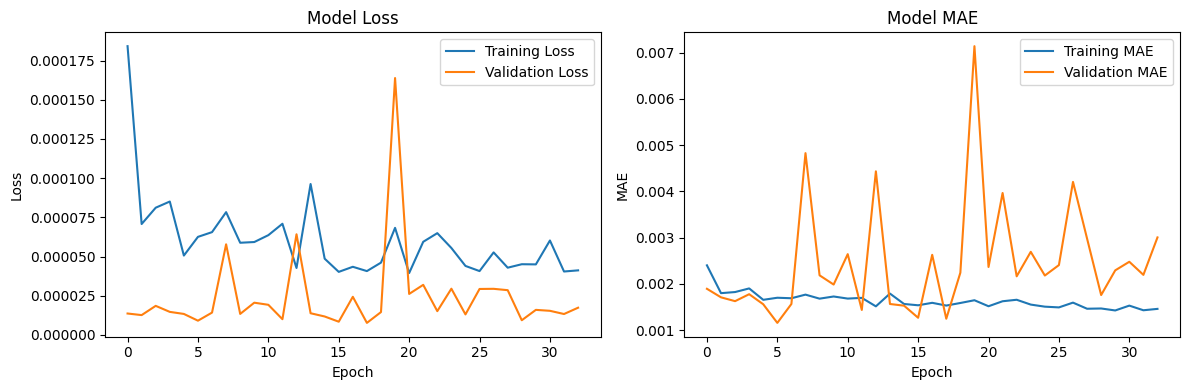

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 506,309 (1.93 MB)

 Trainable params: 168,769 (659.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 337,540 (1.29 MB)


Test Set Metrics:
MAE: 0.0010
RMSE: 0.0013
R²: -0.5192


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_train_reshaped
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the model
input_shape = (1, X_train.shape[1])  # (timesteps, features)
model = Sequential([
    LSTM(128, input_shape=input_shape, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Set up callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_dengue_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
history = model.fit(
    X_train_reshaped, 
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_reshaped, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Make predictions
train_predictions = model.predict(X_train_reshaped)
test_predictions = model.predict(X_test_reshaped)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Print model summary
model.summary()

# Calculate and print additional metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For test set
test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print("\nTest Set Metrics:")
print(f"MAE: {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²: {test_r2:.4f}")




In [287]:
test_predictions

array([[0.00022082],
       [0.00022082],
       [0.00022082],
       ...,
       [0.00022082],
       [0.00022082],
       [0.00022082]], dtype=float32)

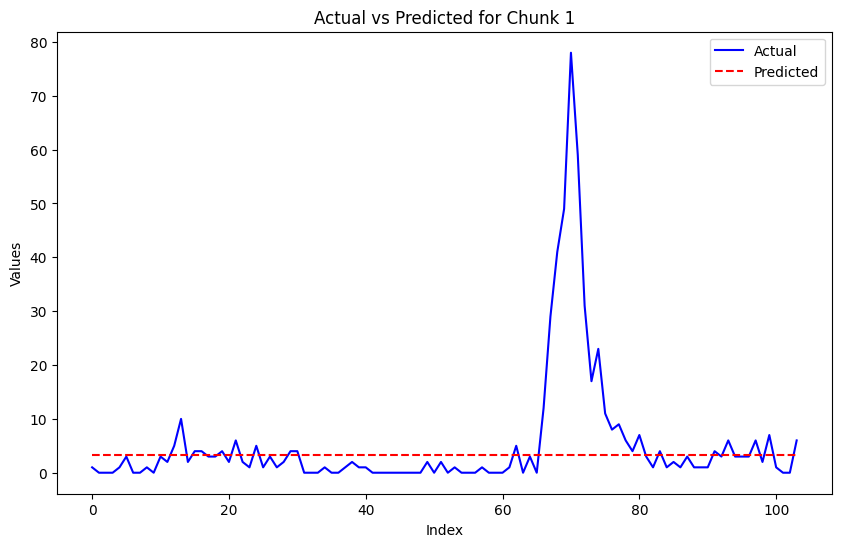

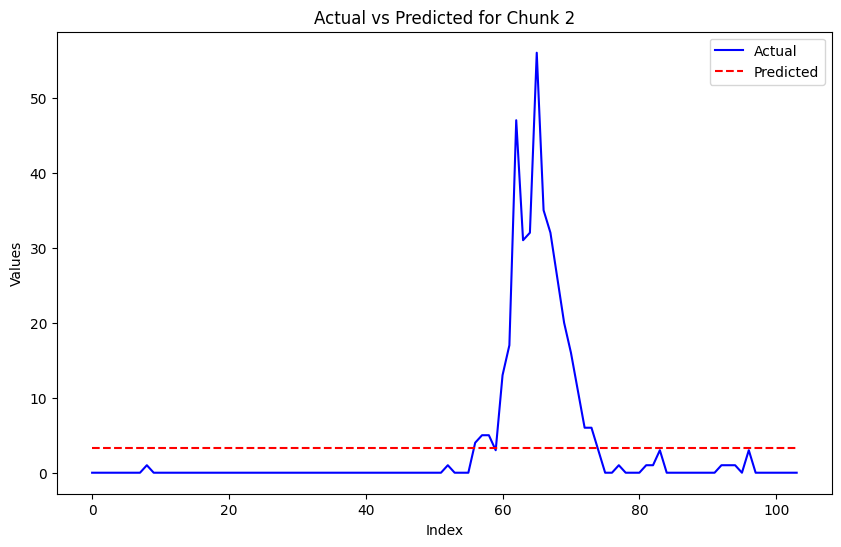

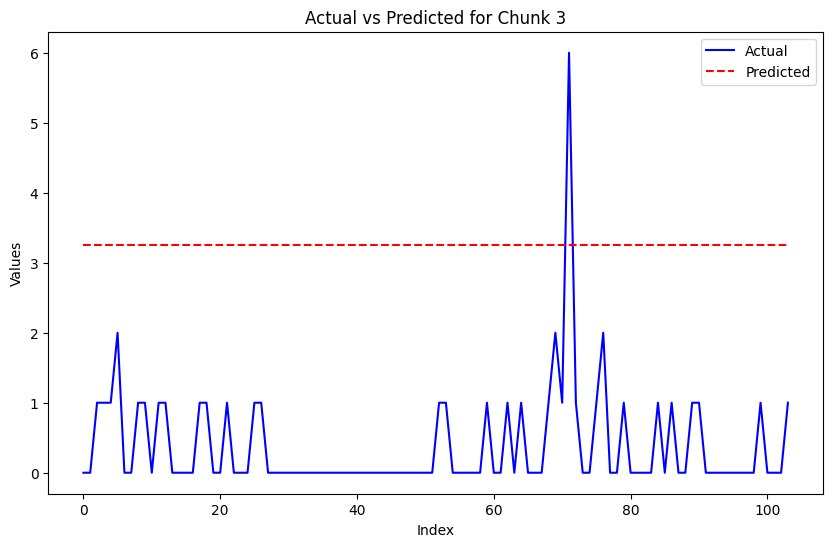

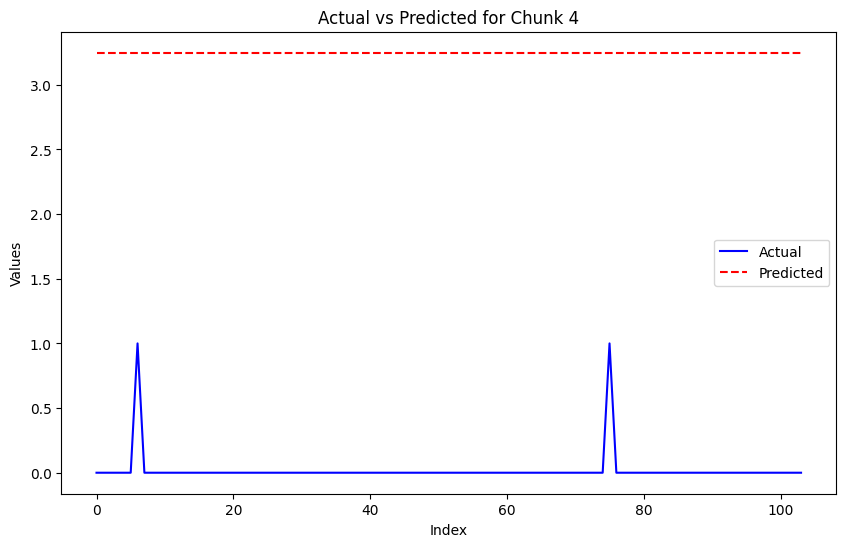

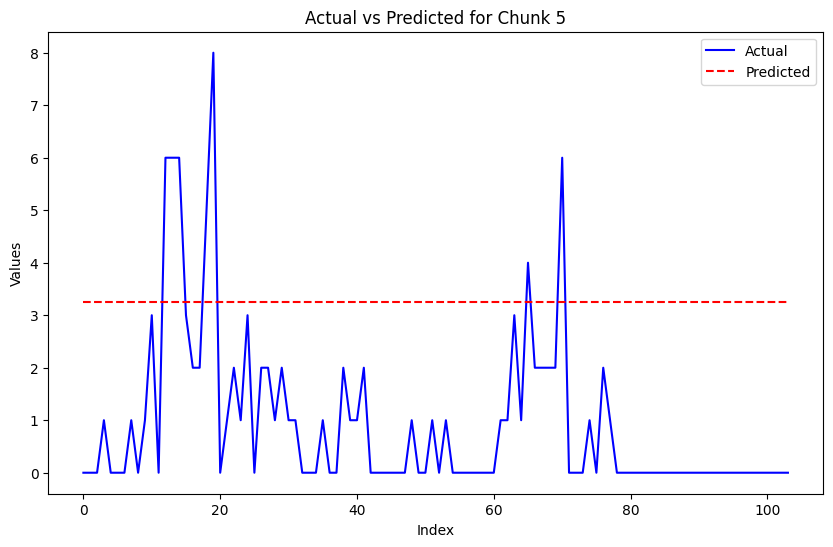

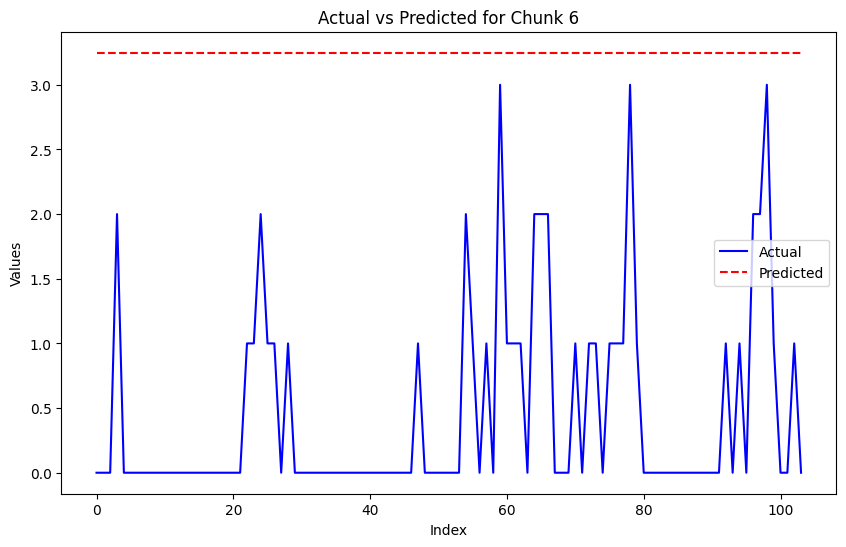

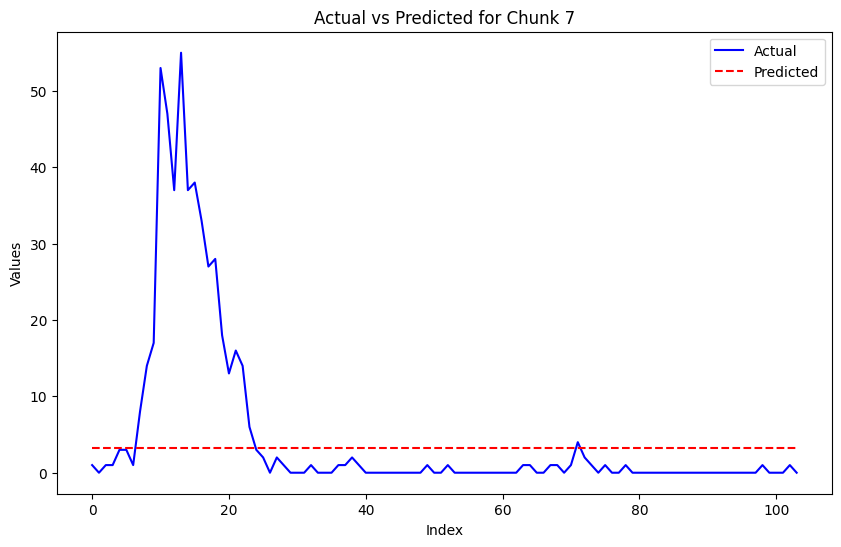

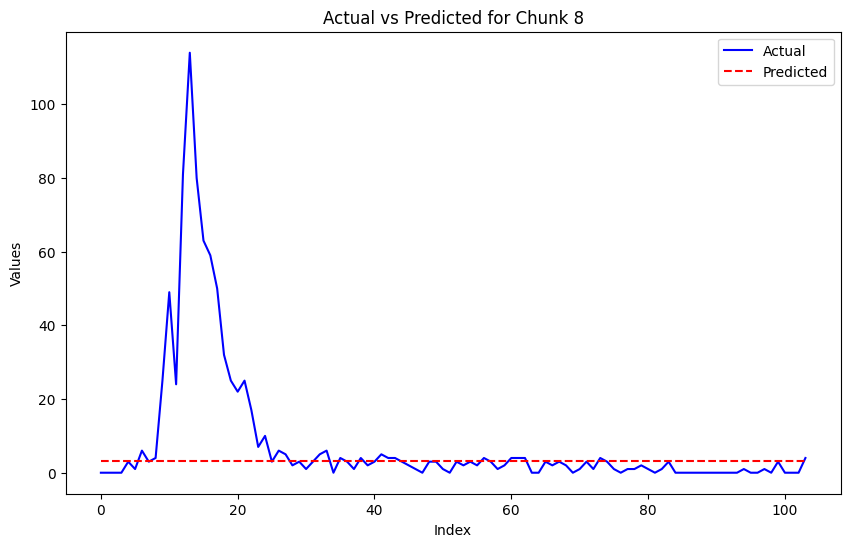

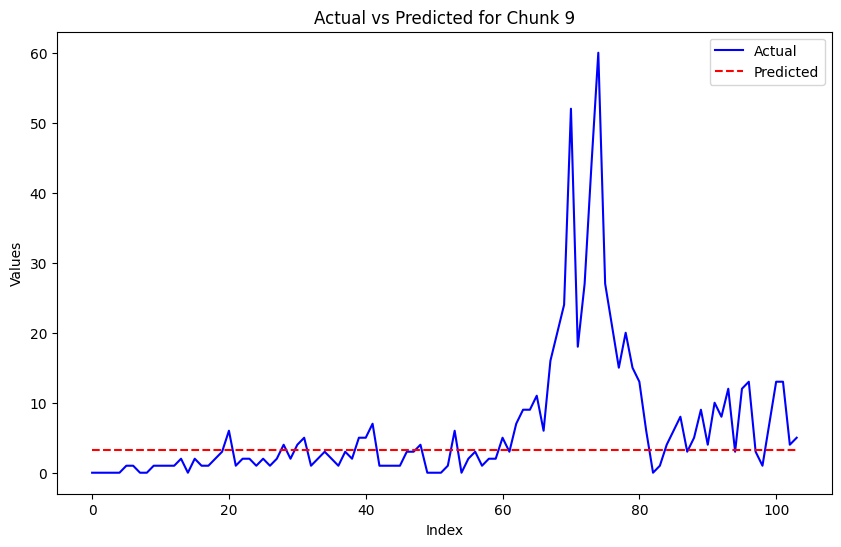

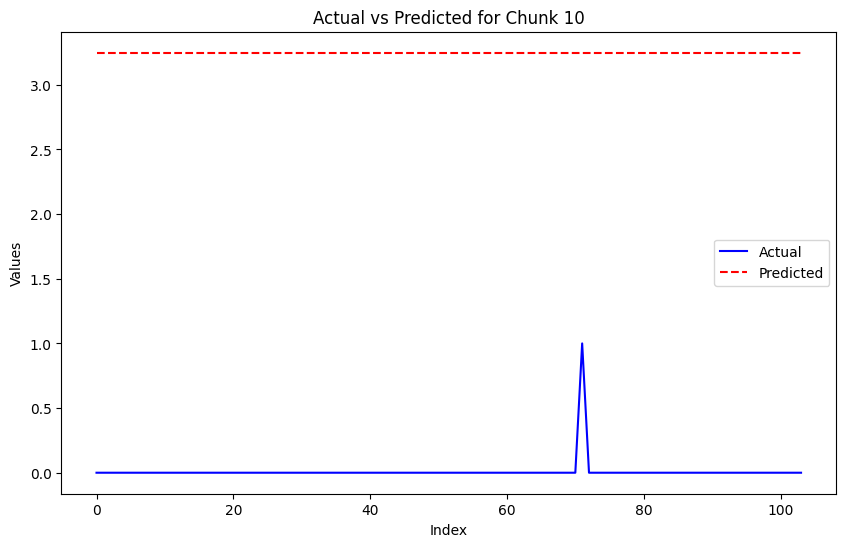

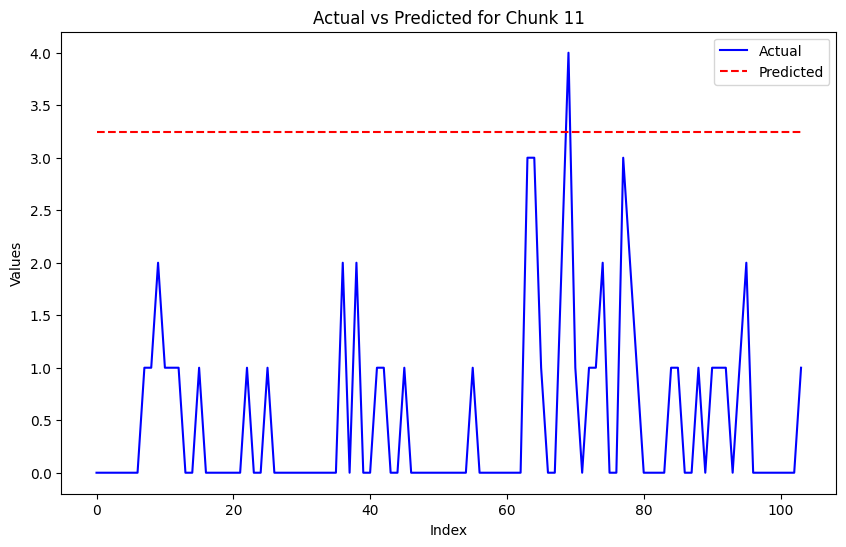

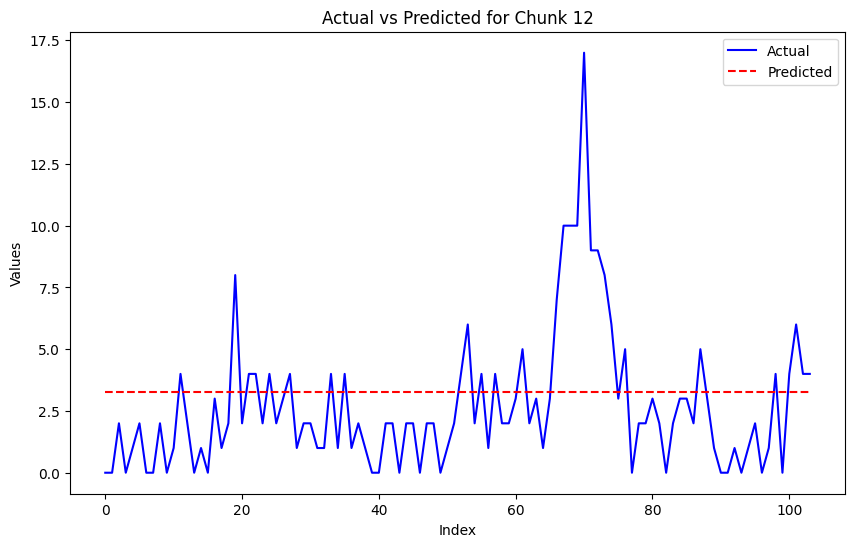

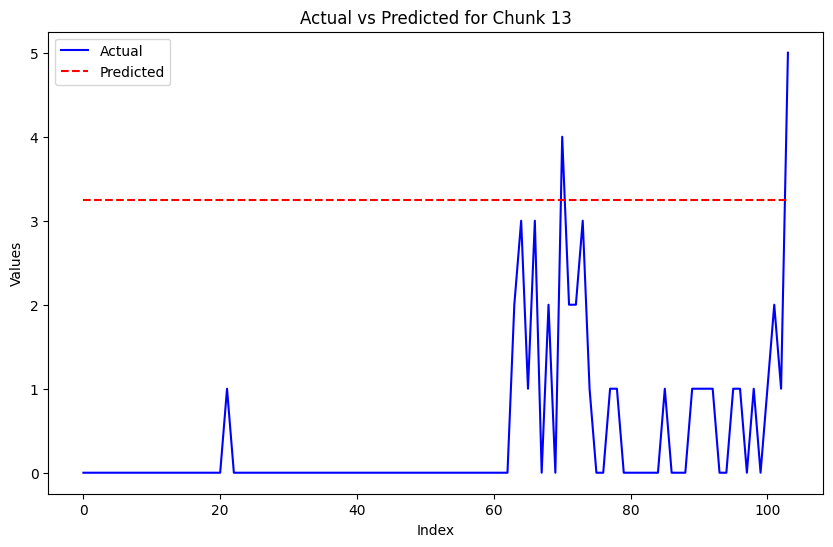

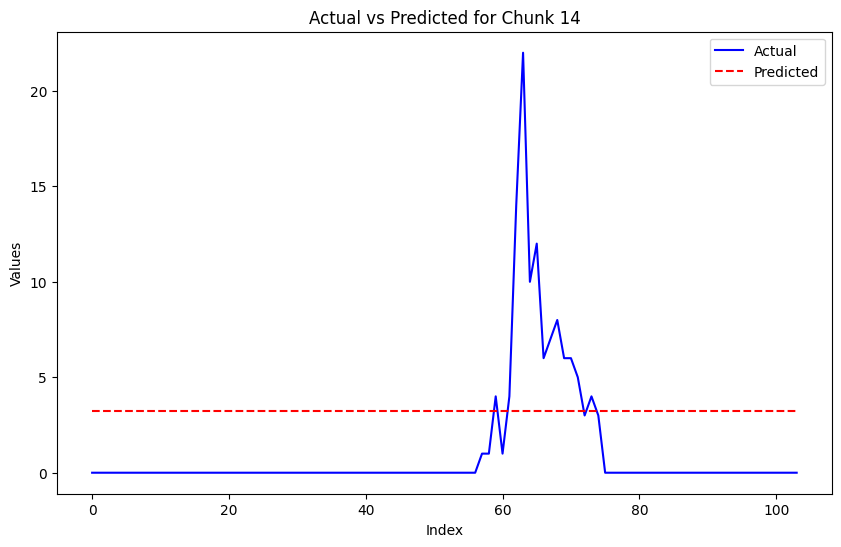

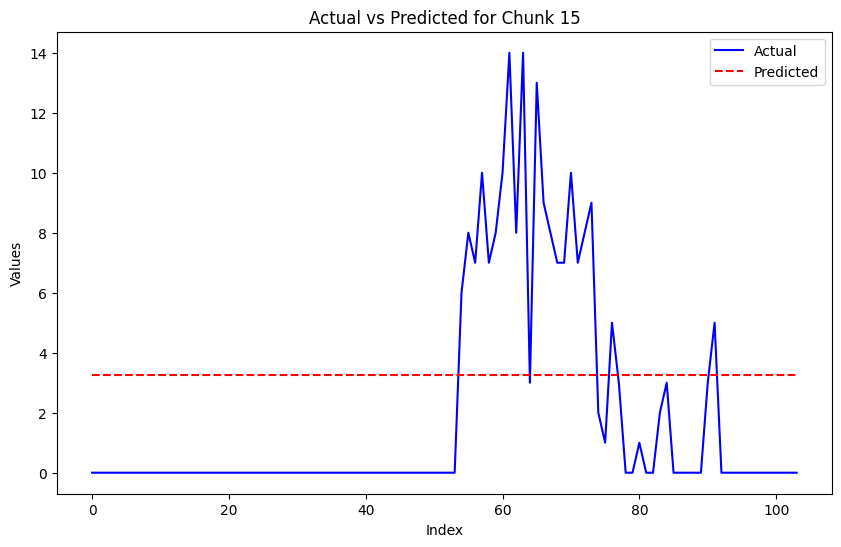

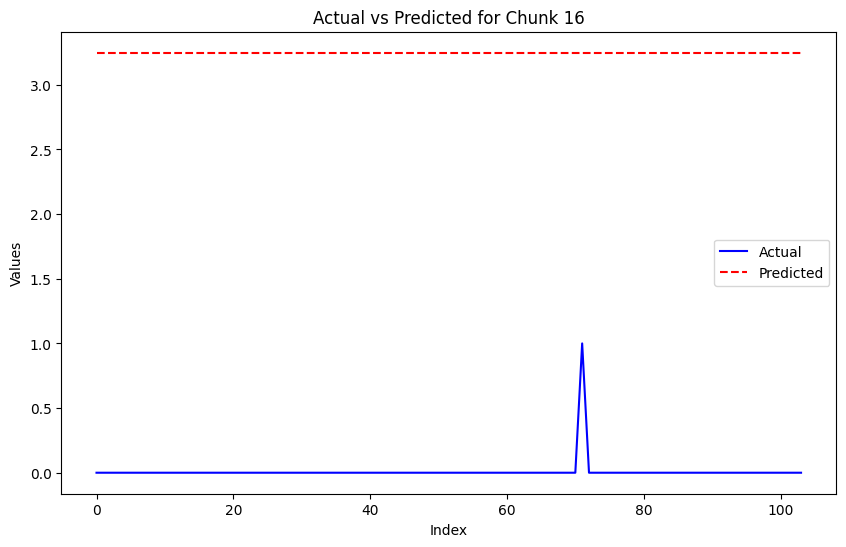

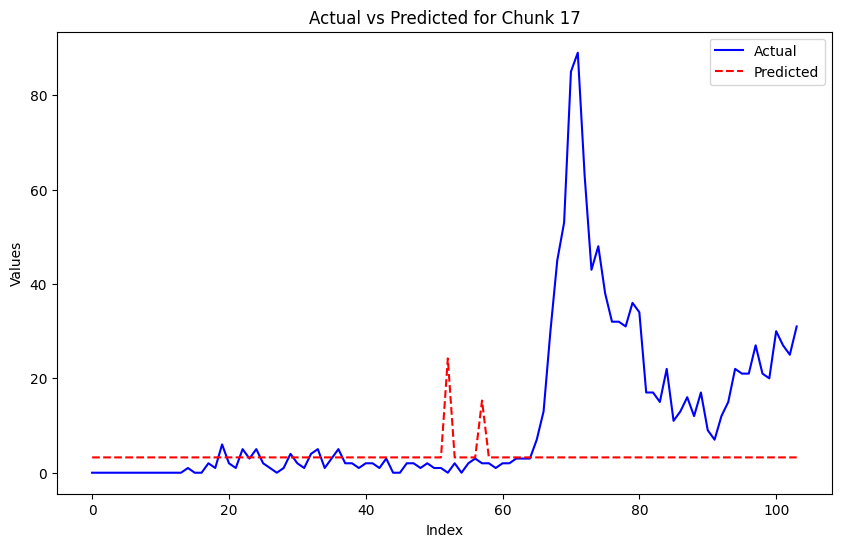

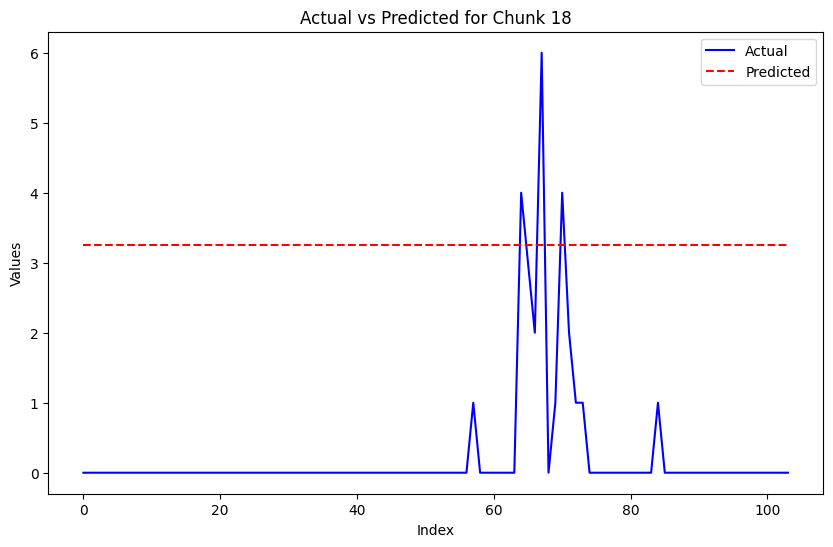

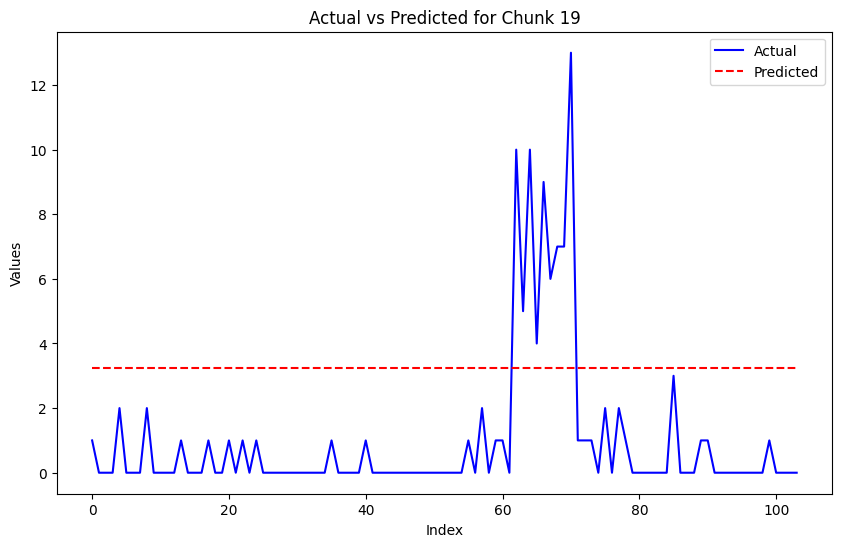

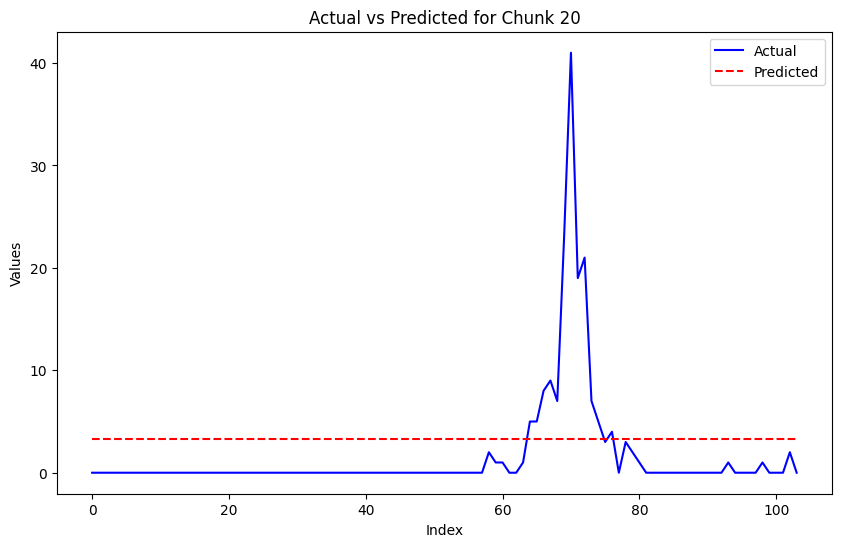

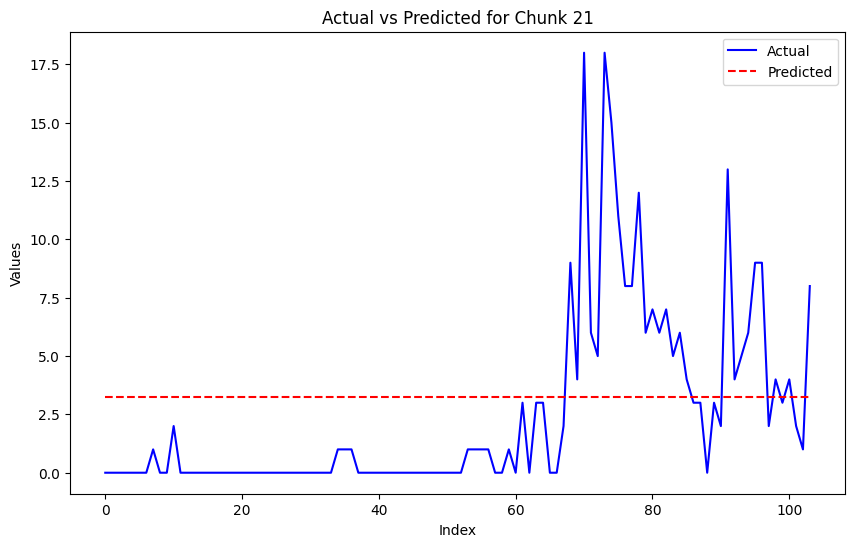

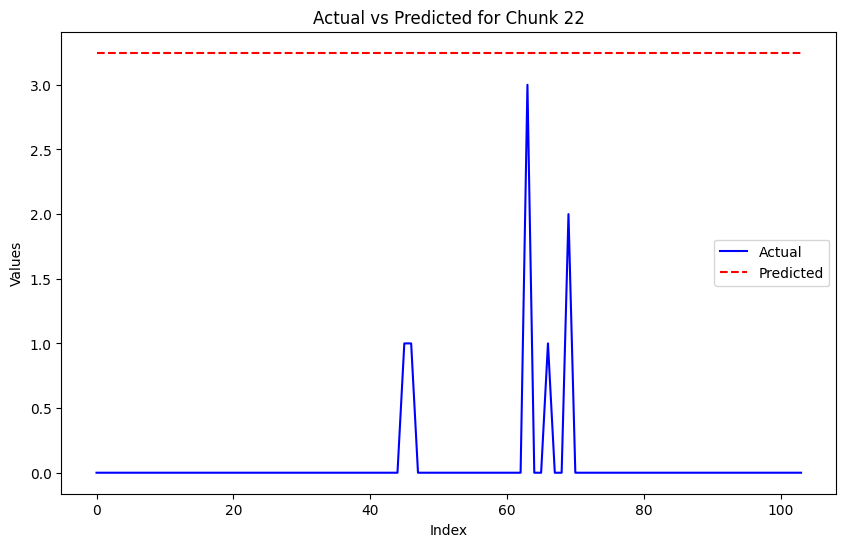

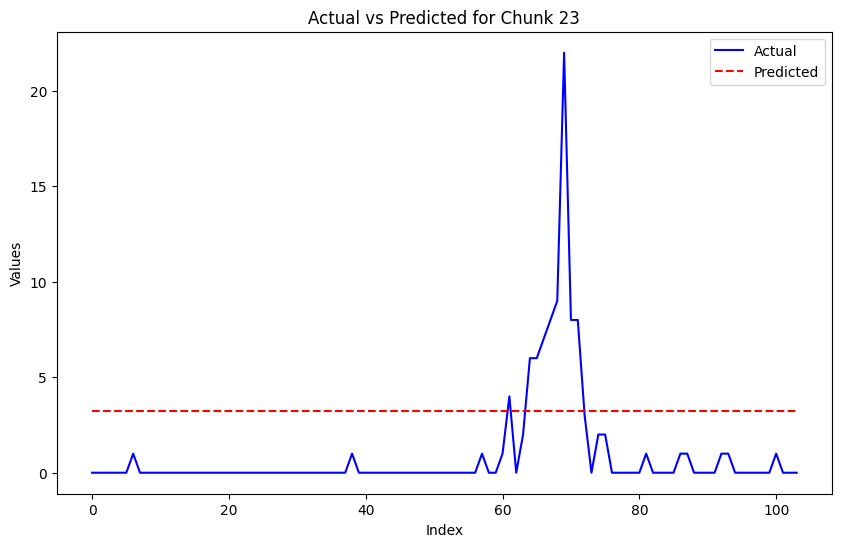

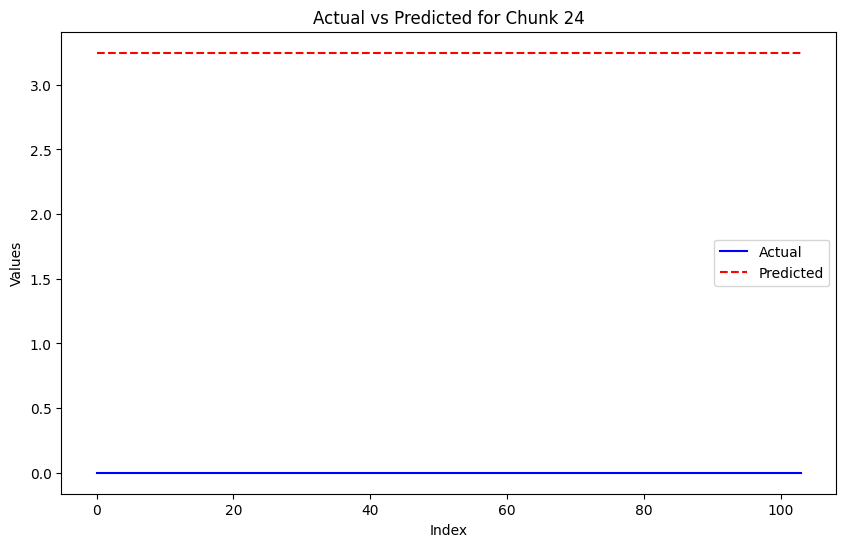

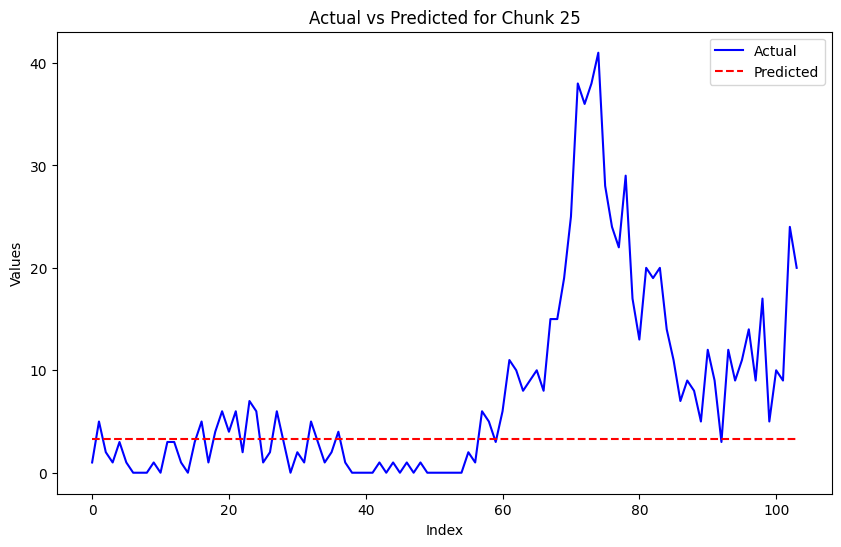

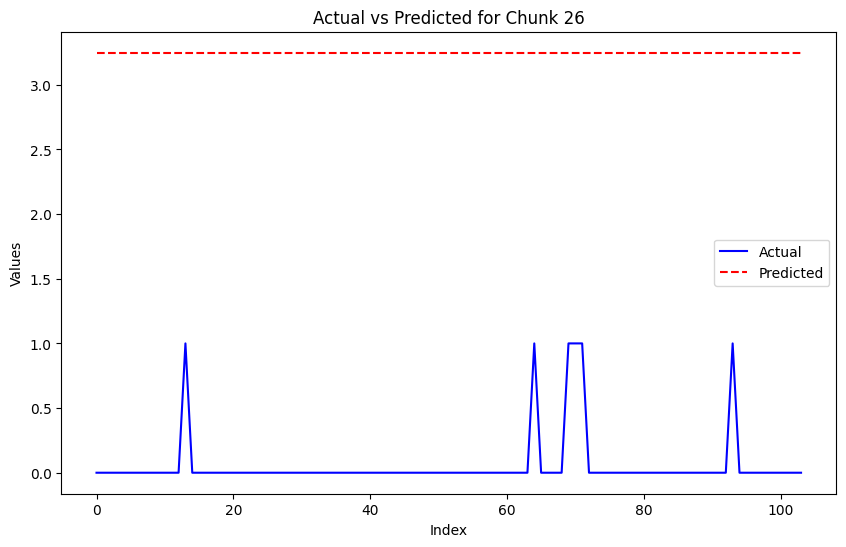

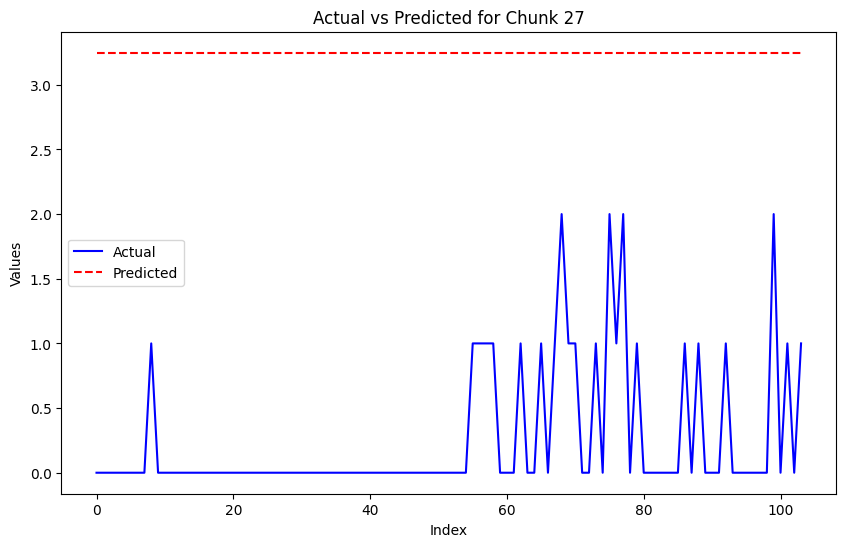

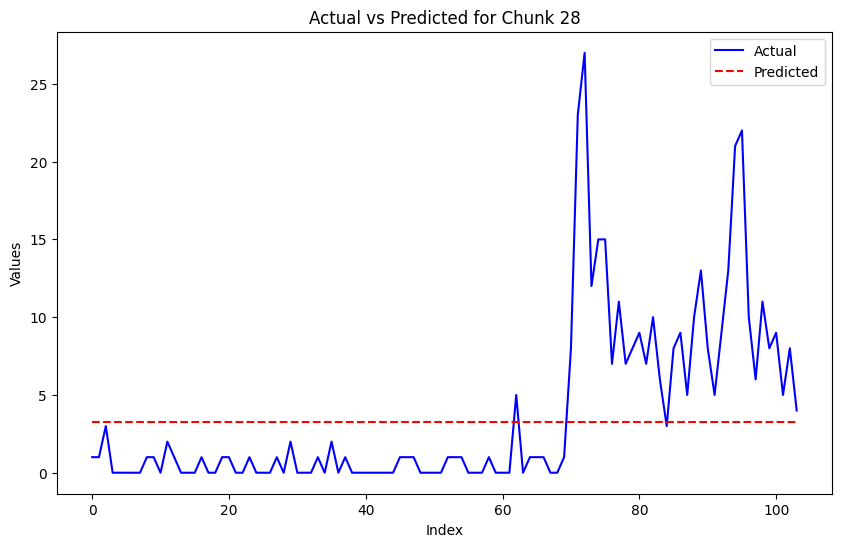

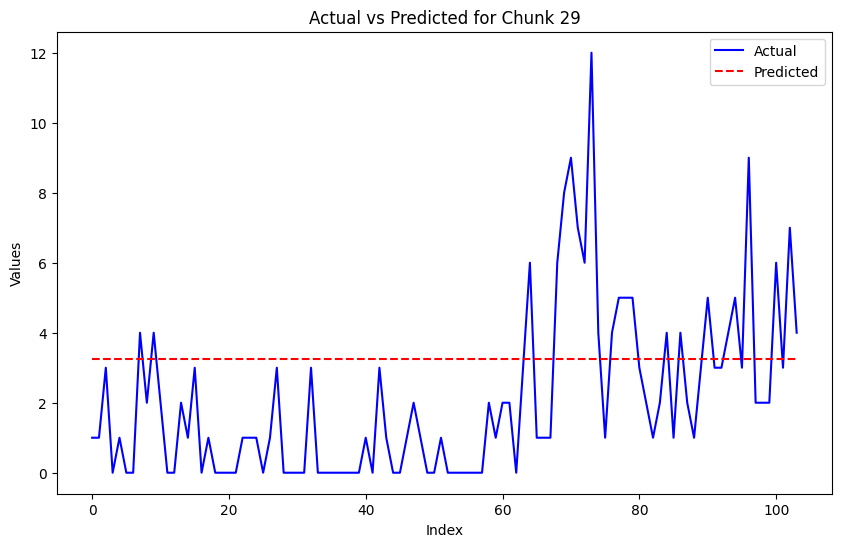

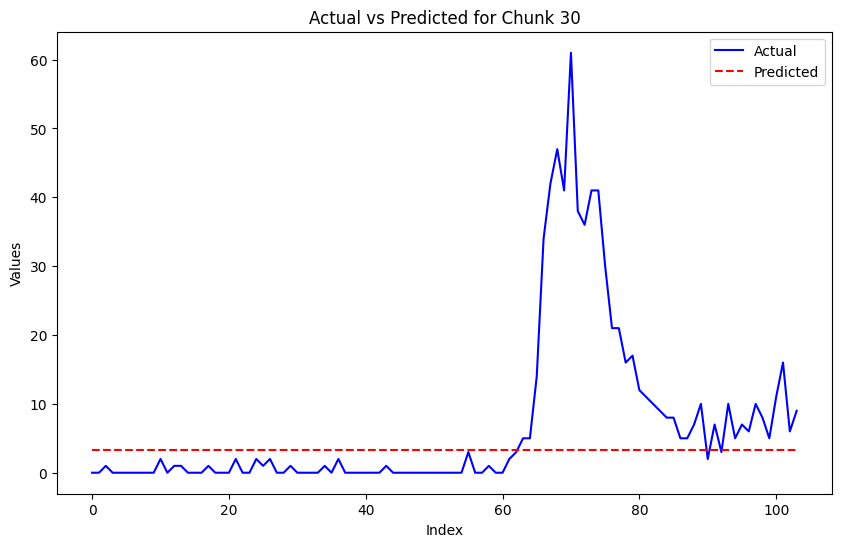

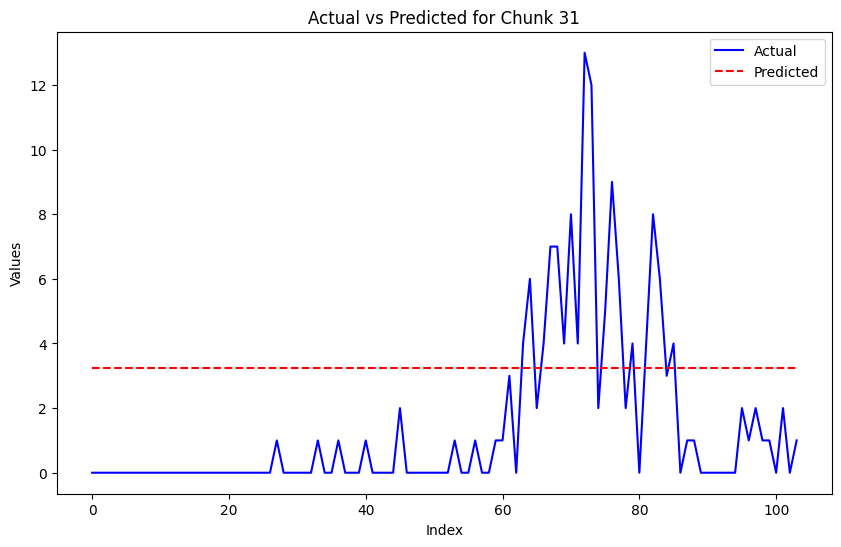

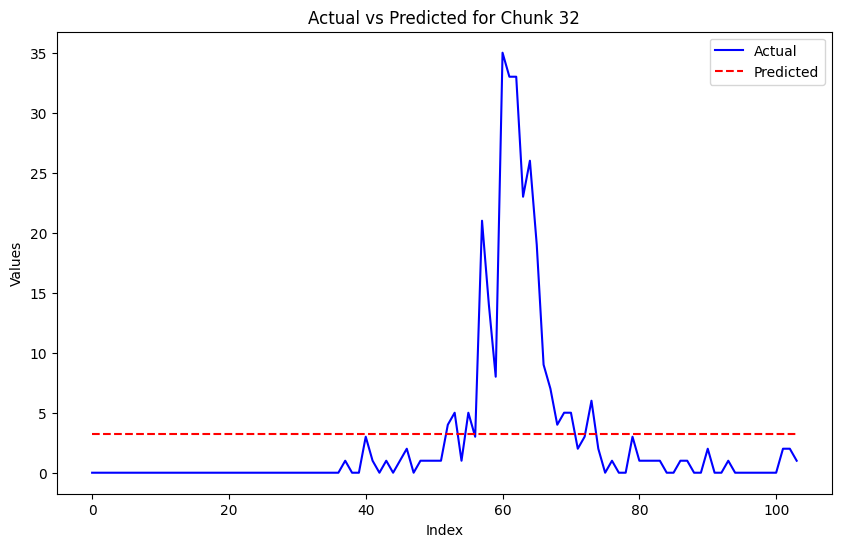

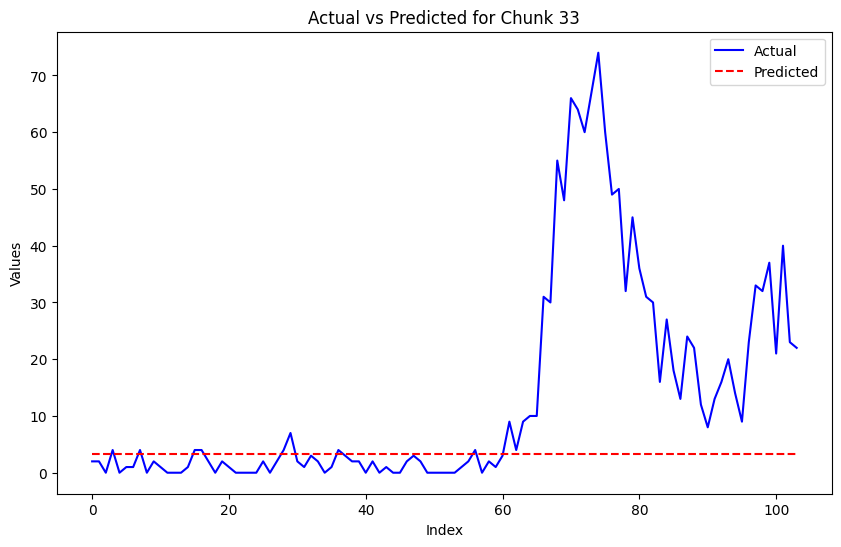

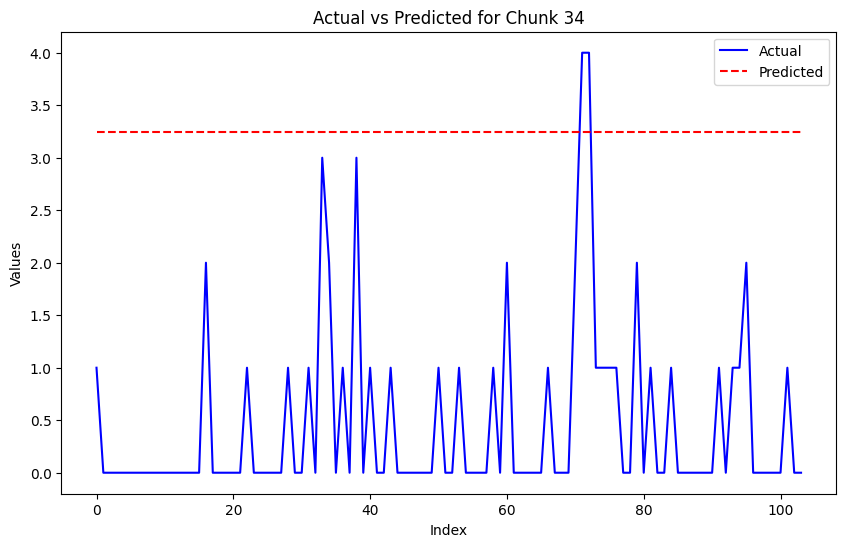

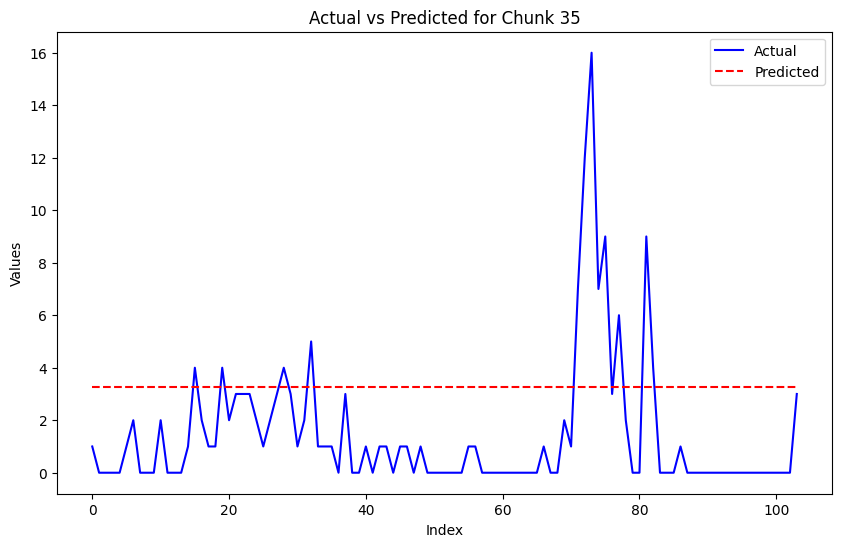

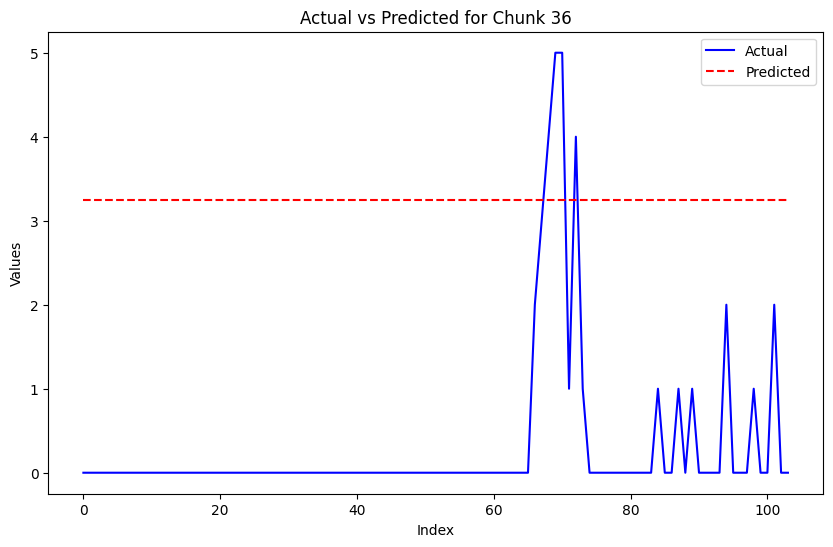

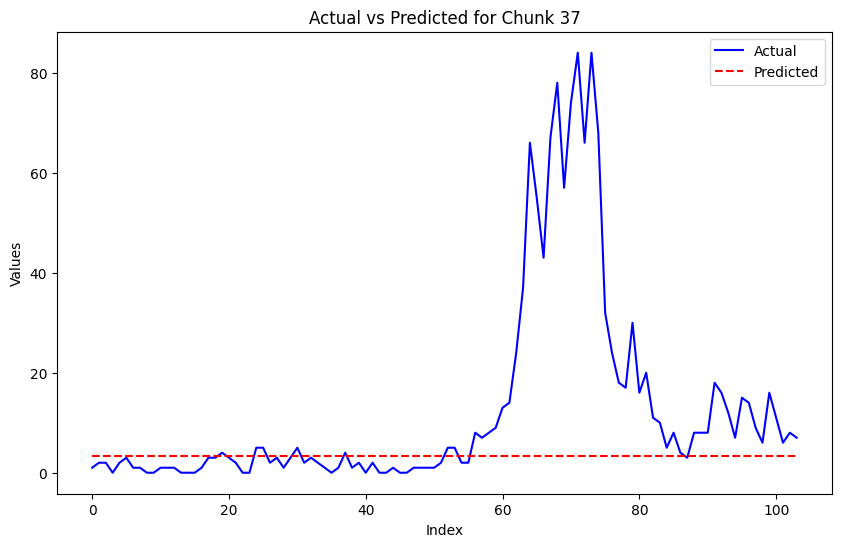

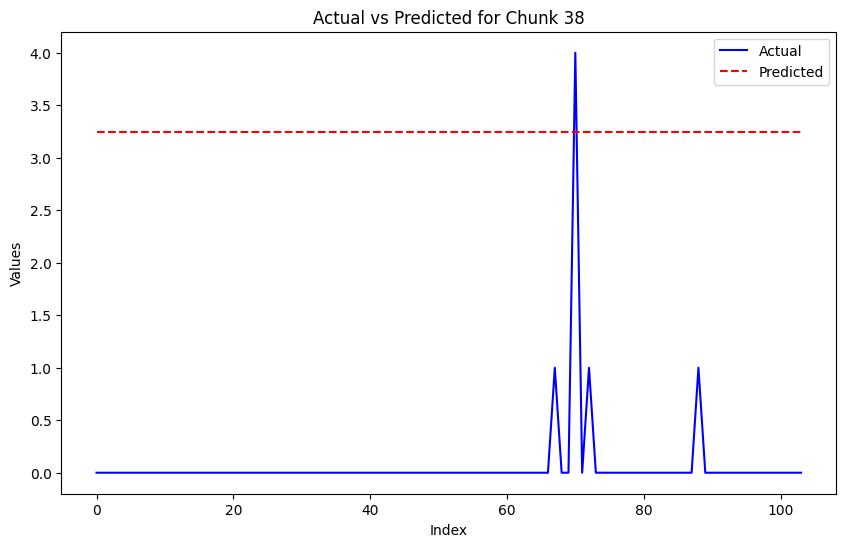

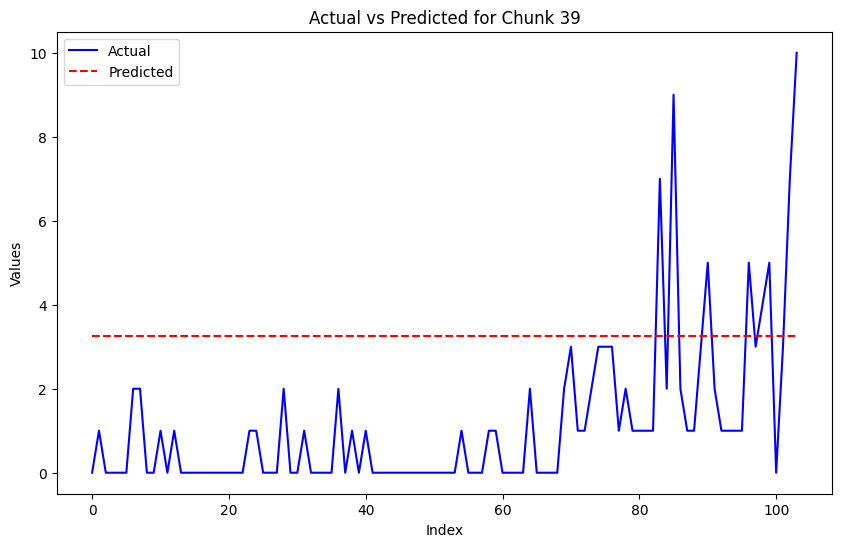

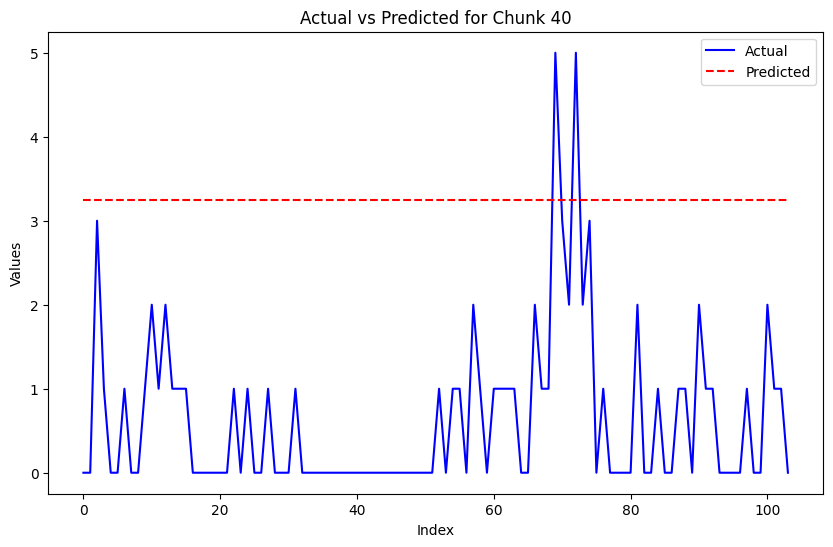

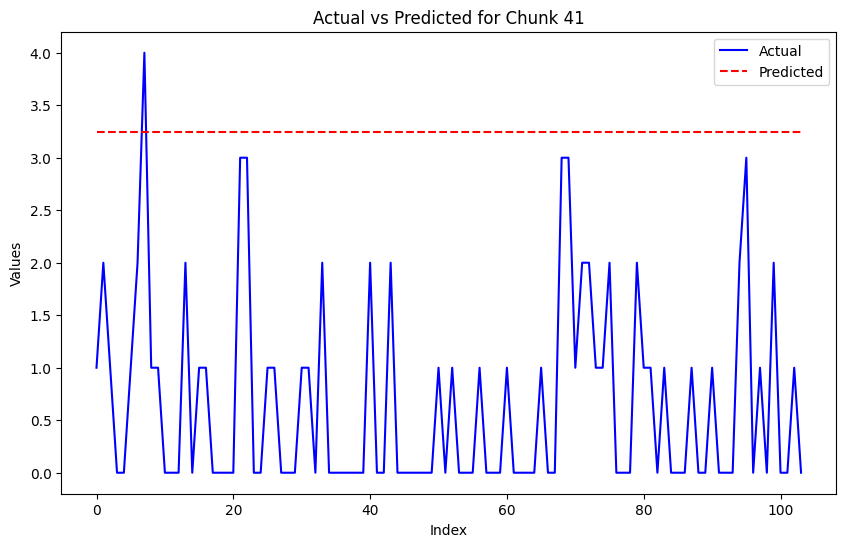

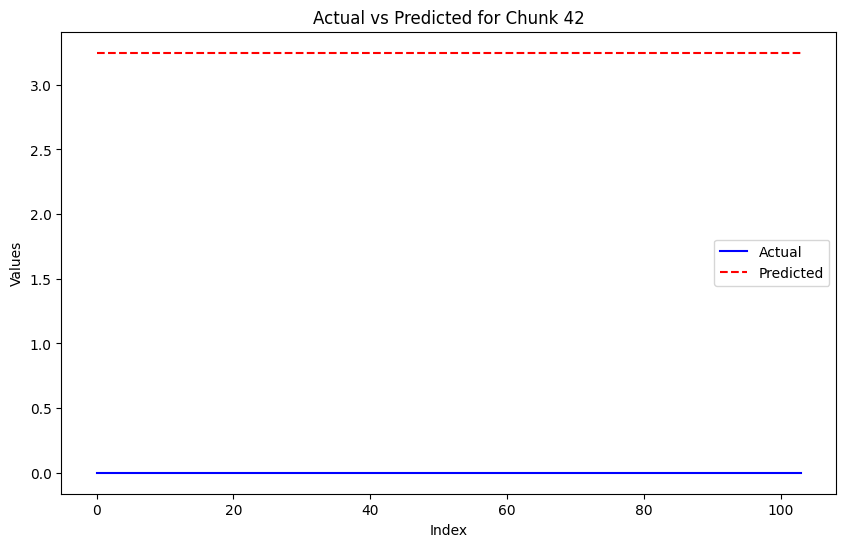

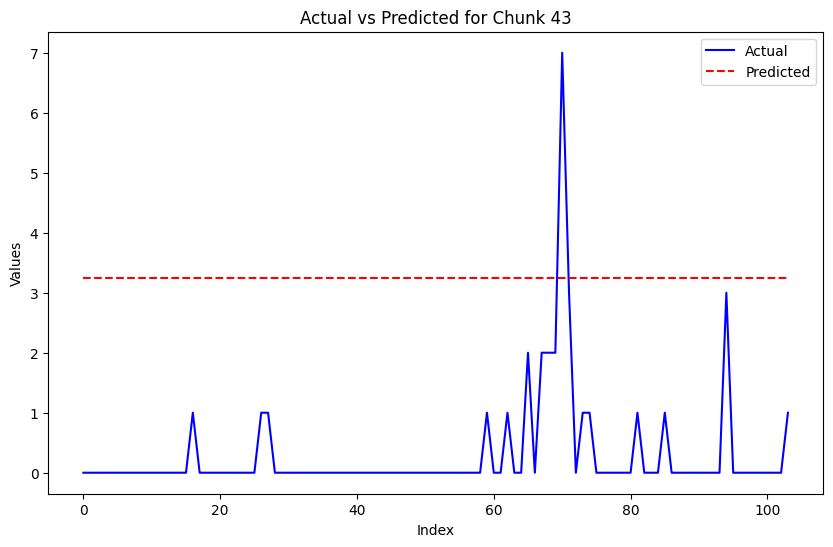

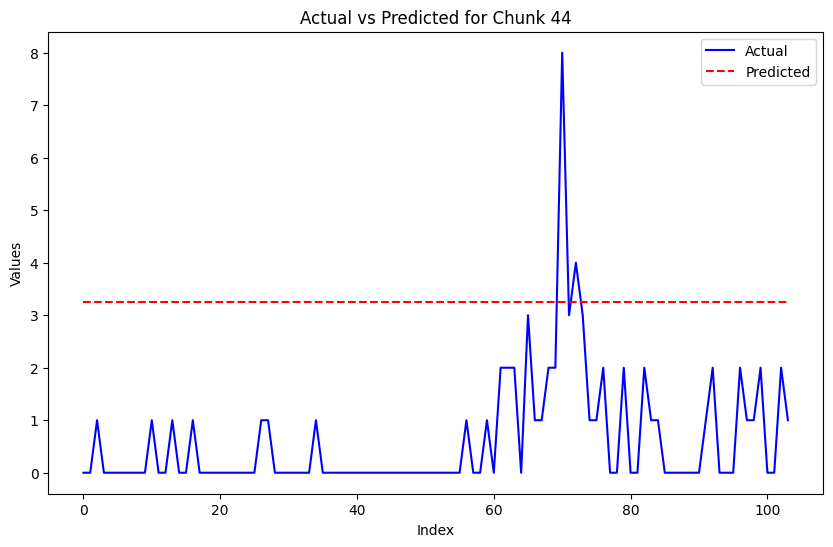

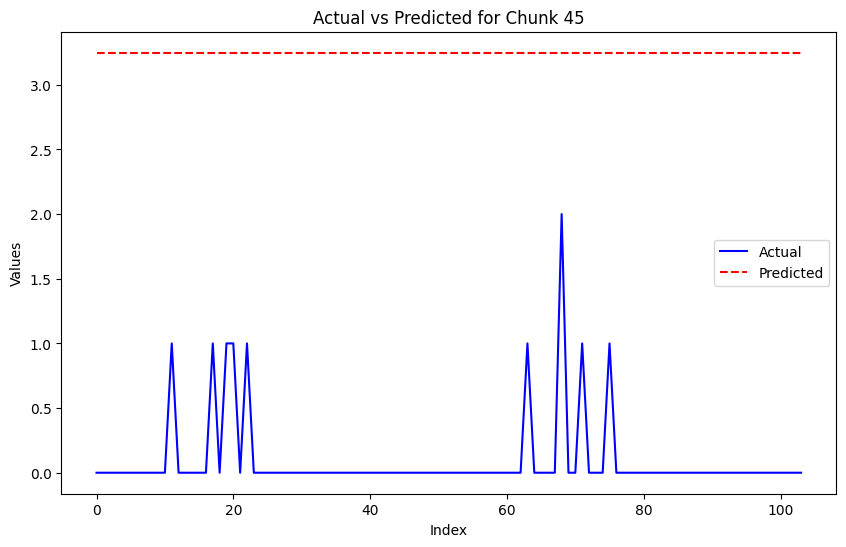

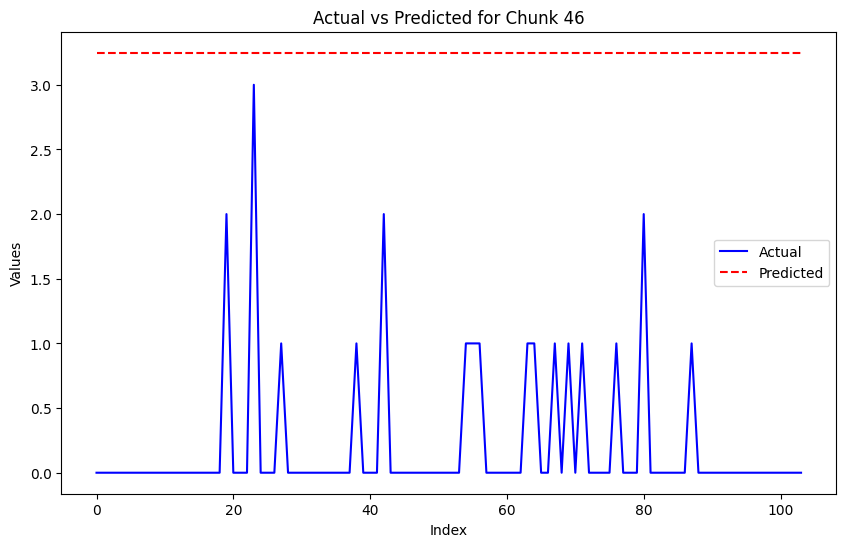

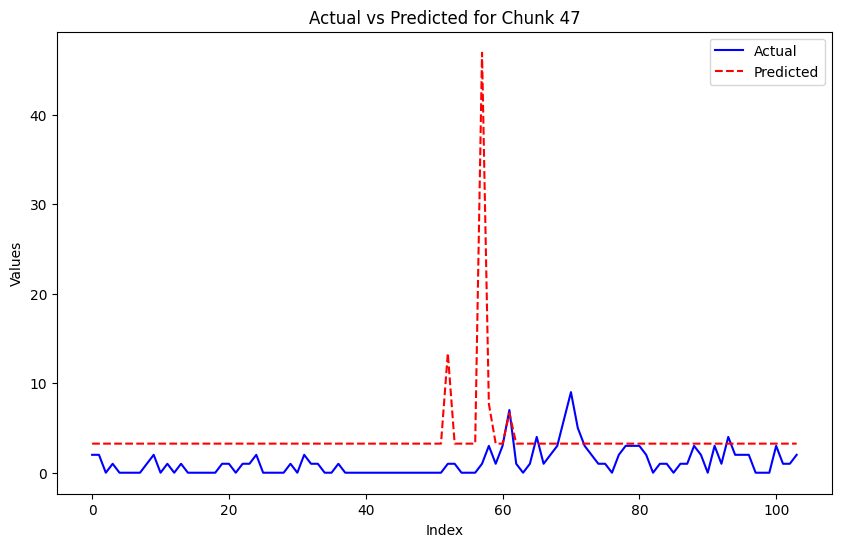

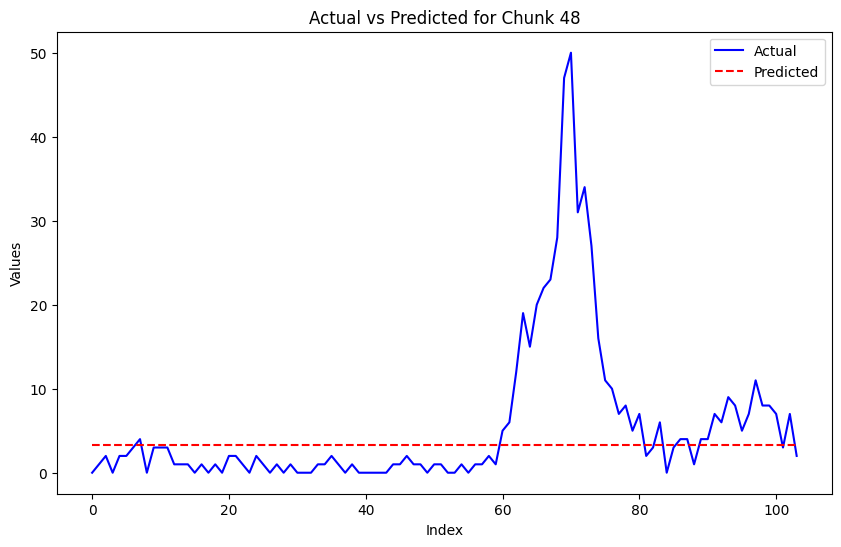

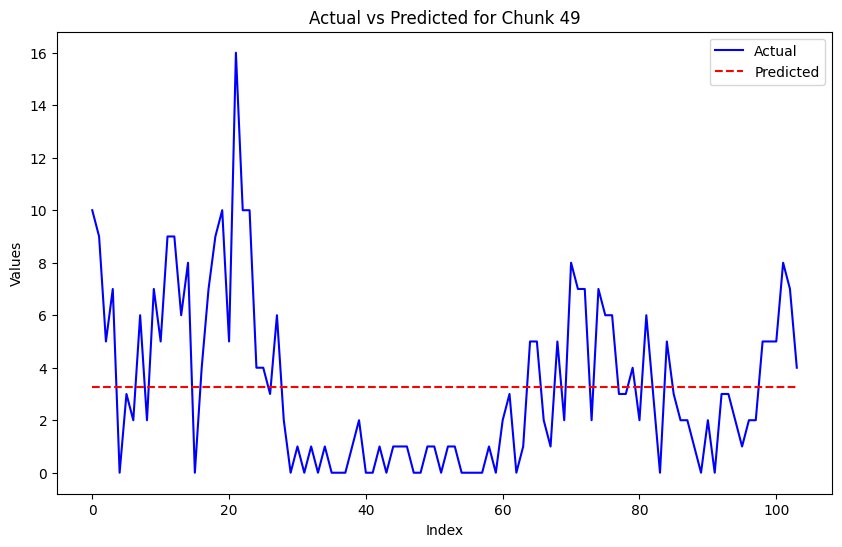

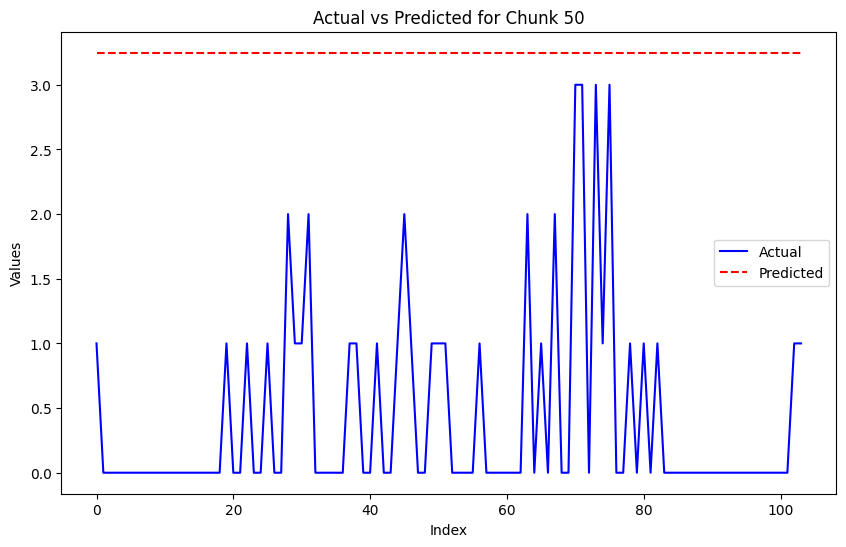

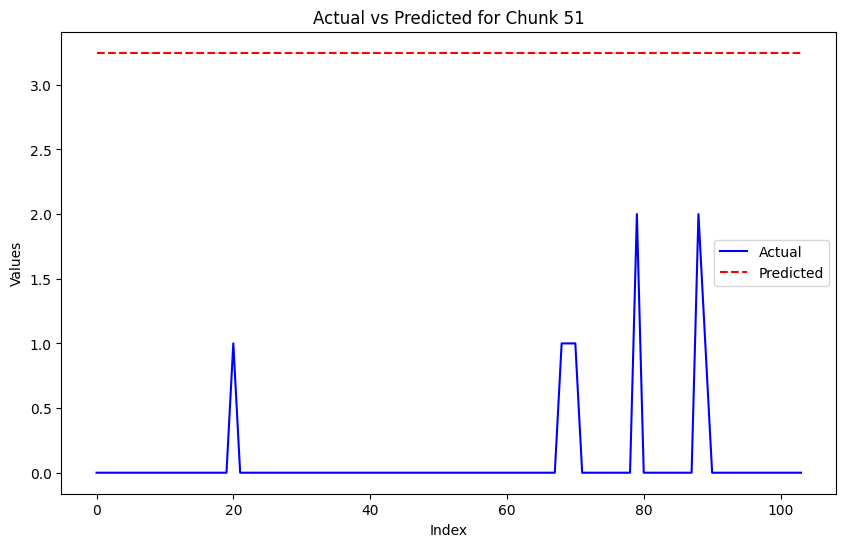

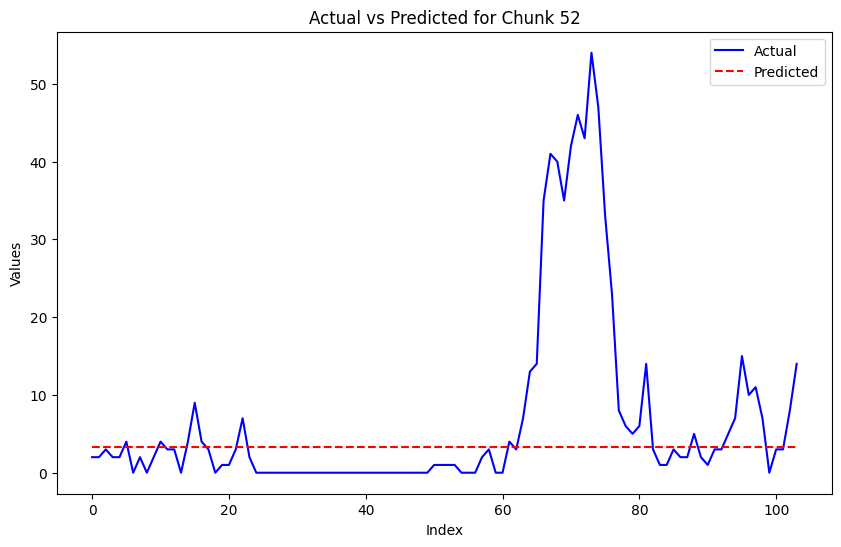

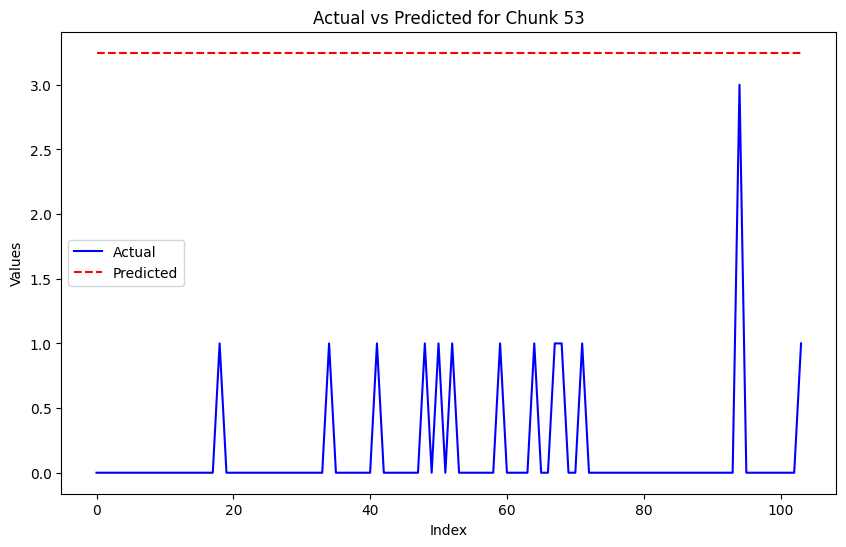

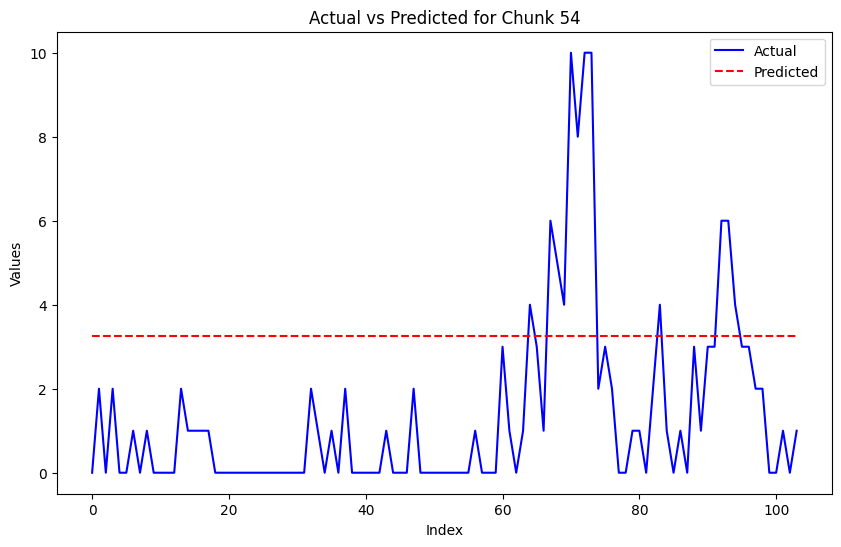

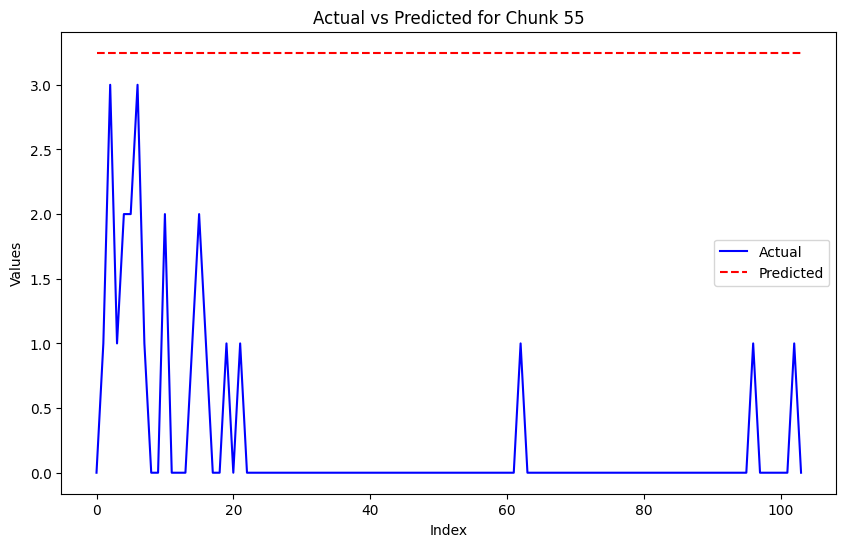

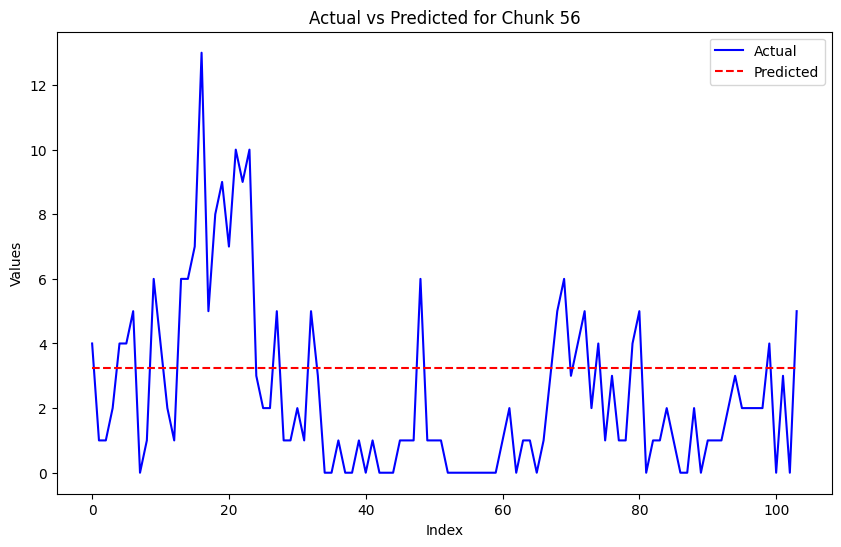

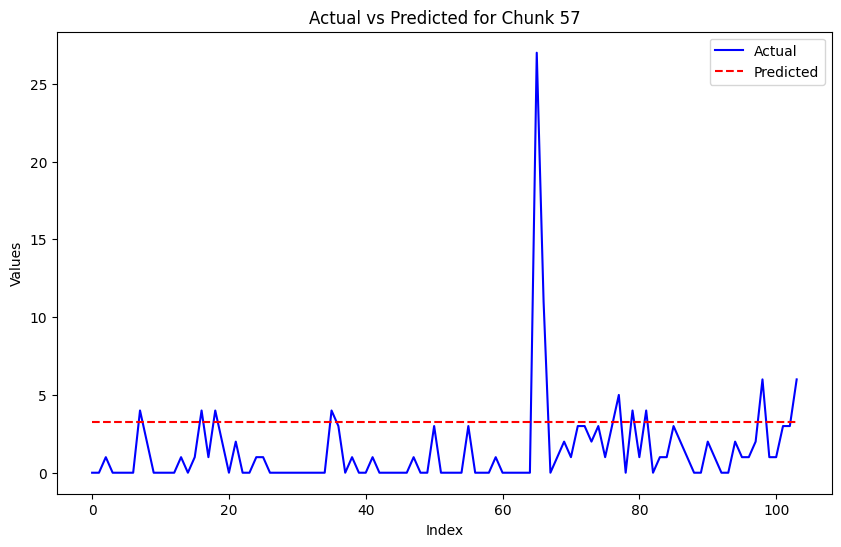

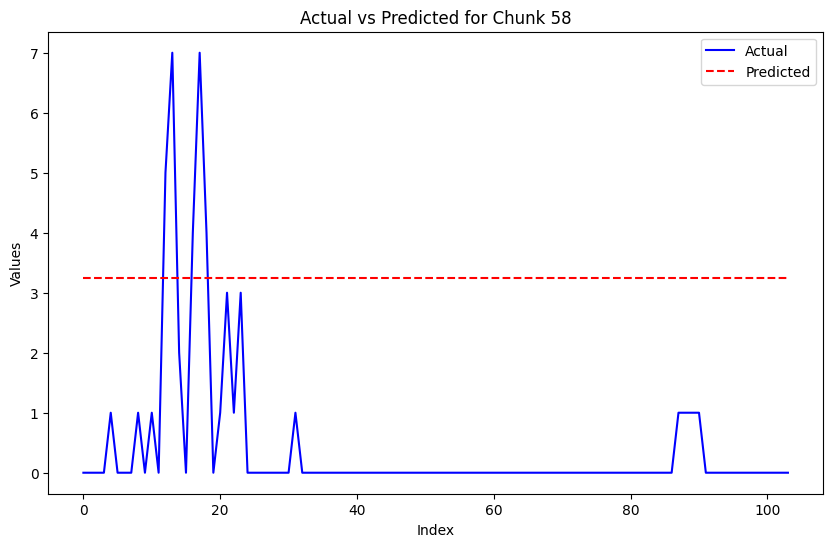

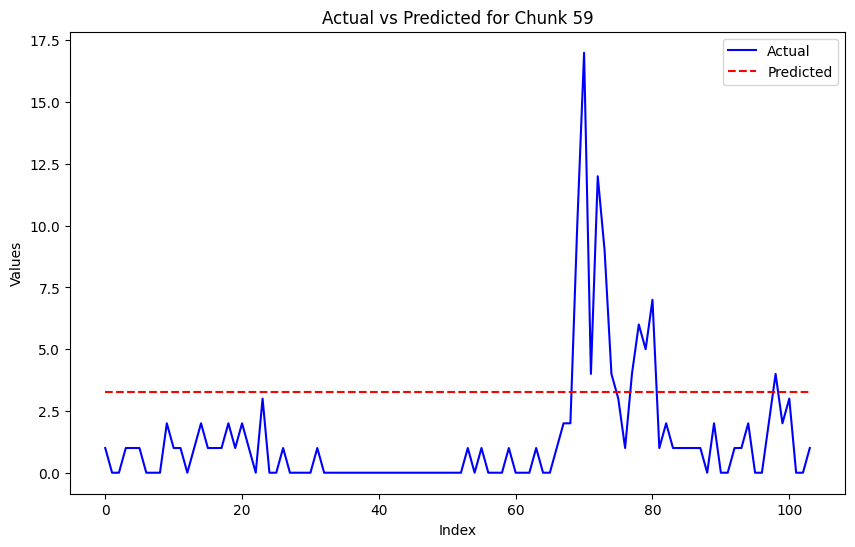

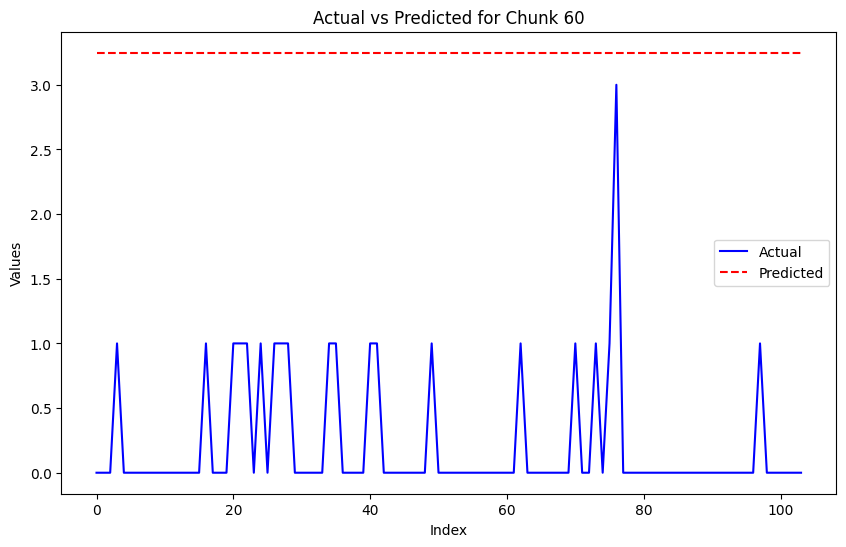

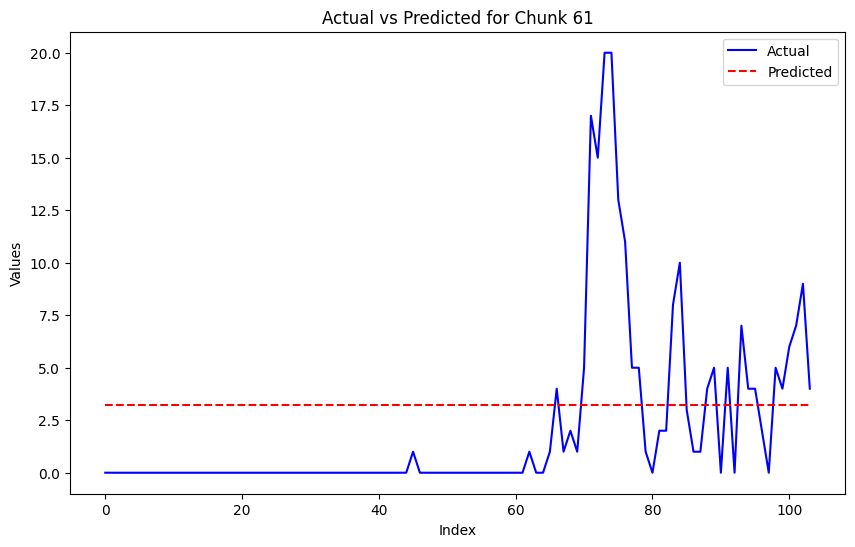

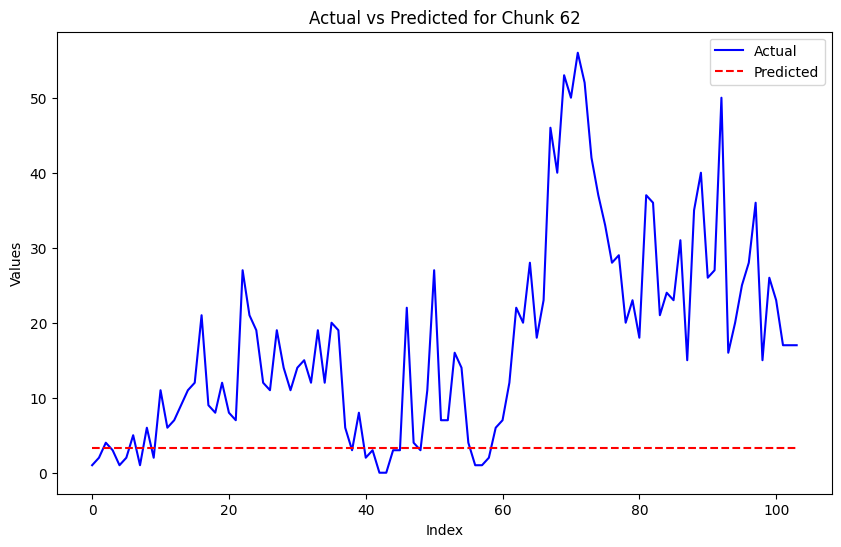

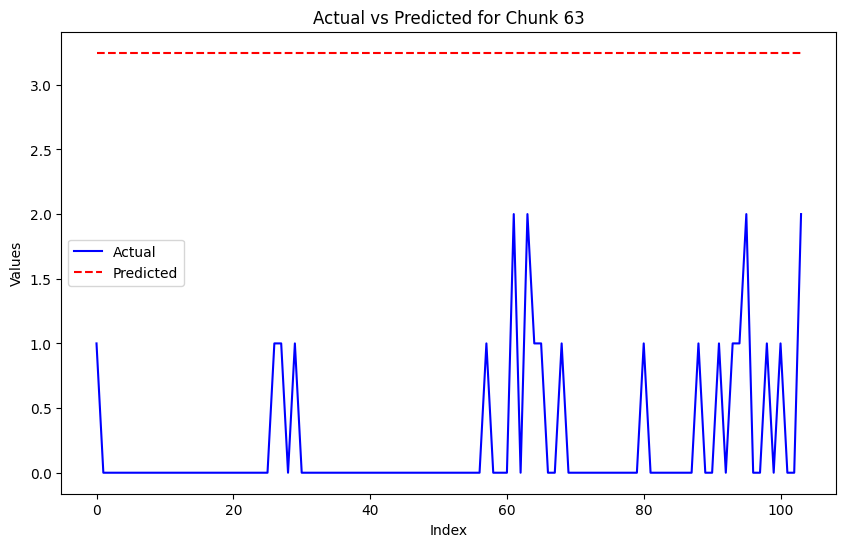

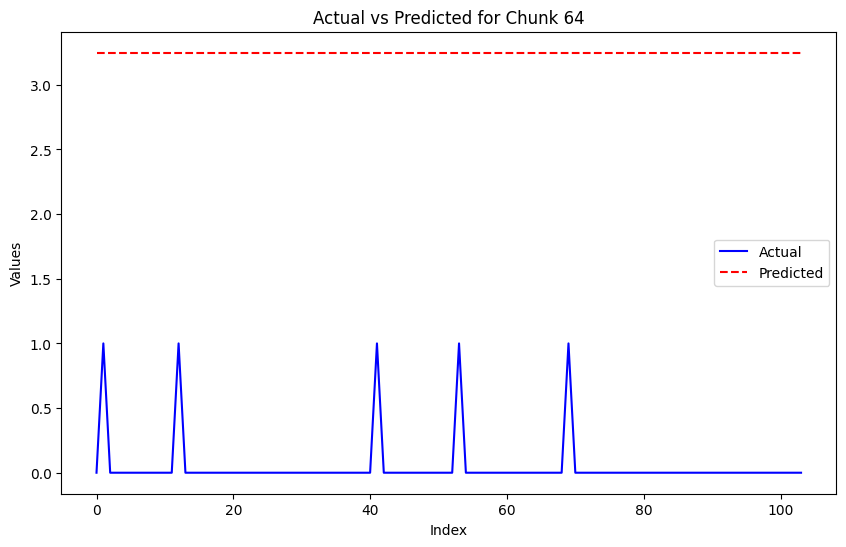

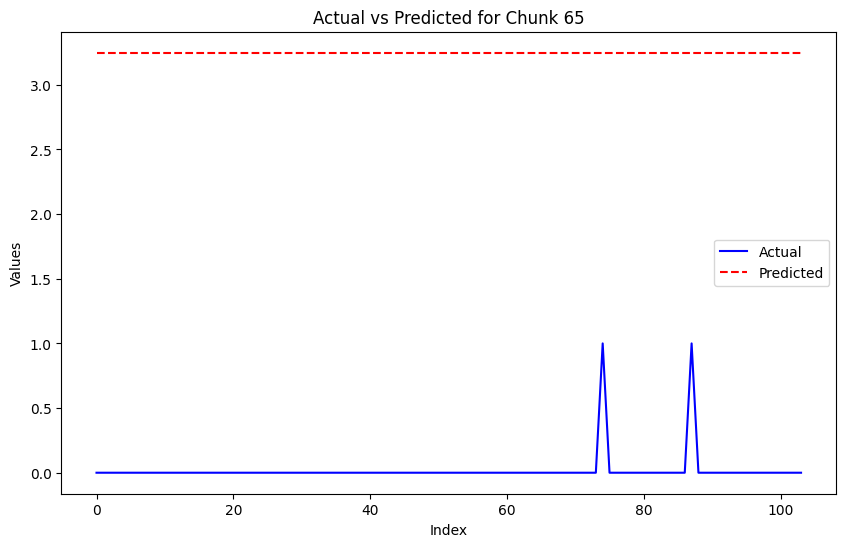

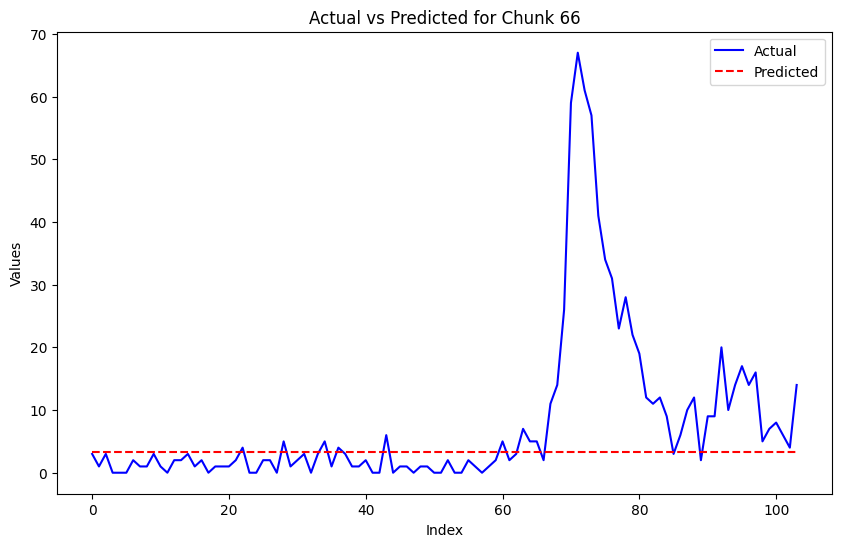

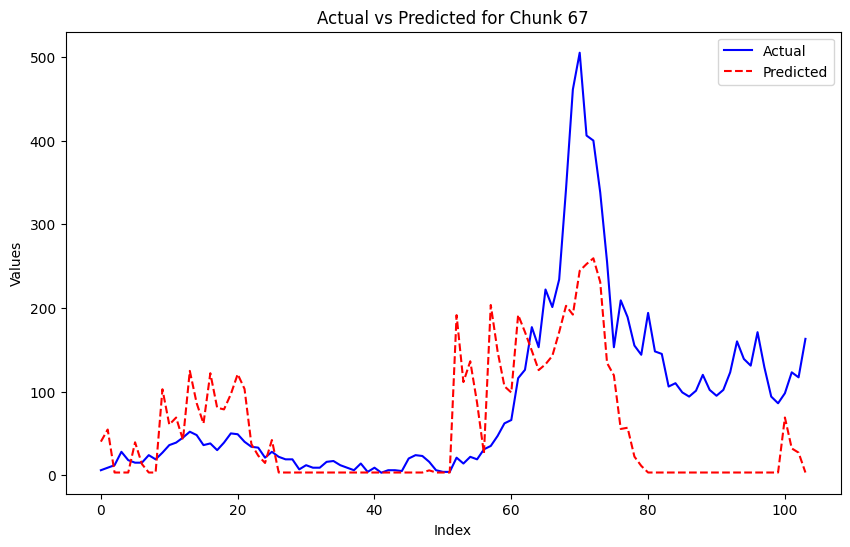

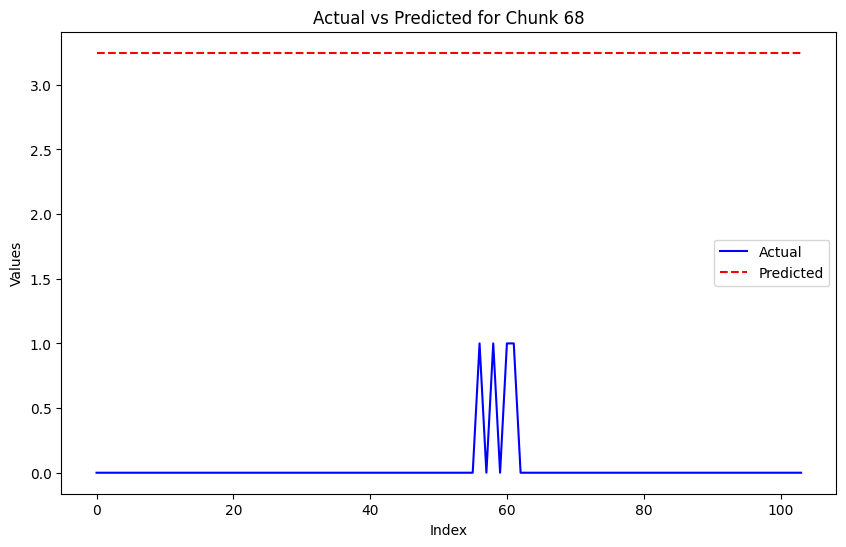

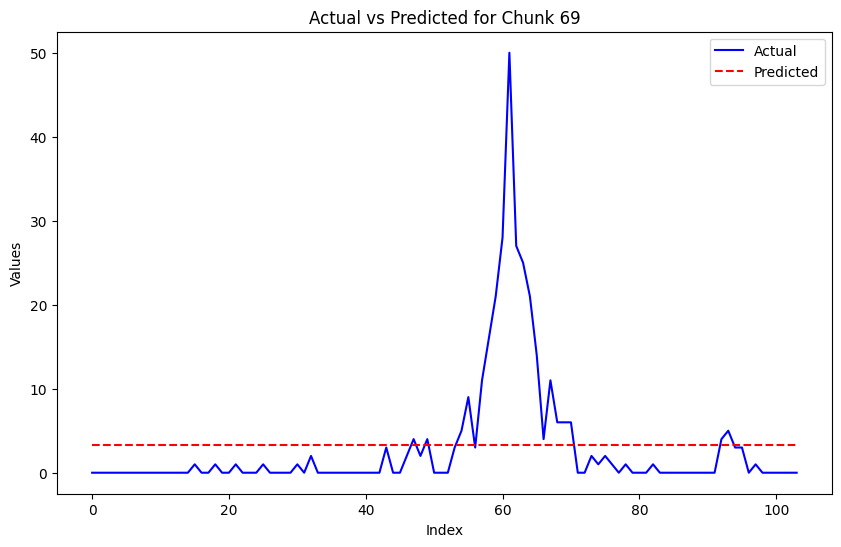

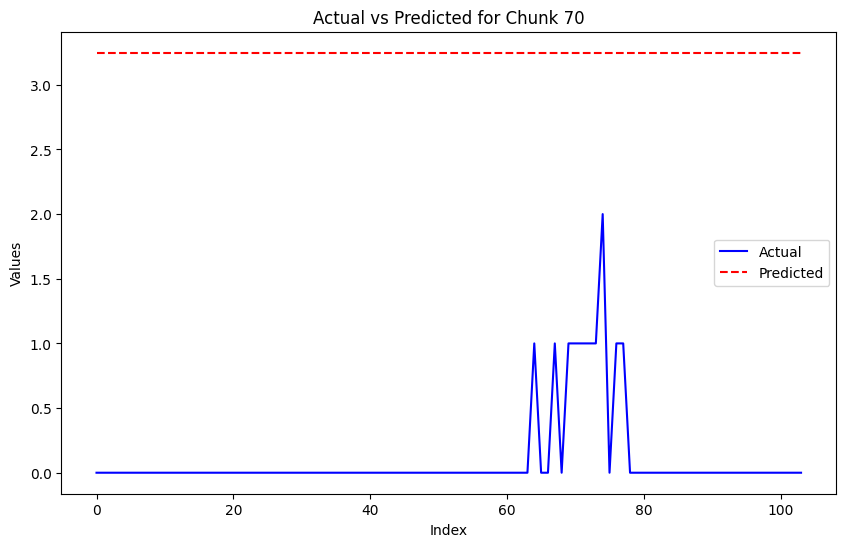

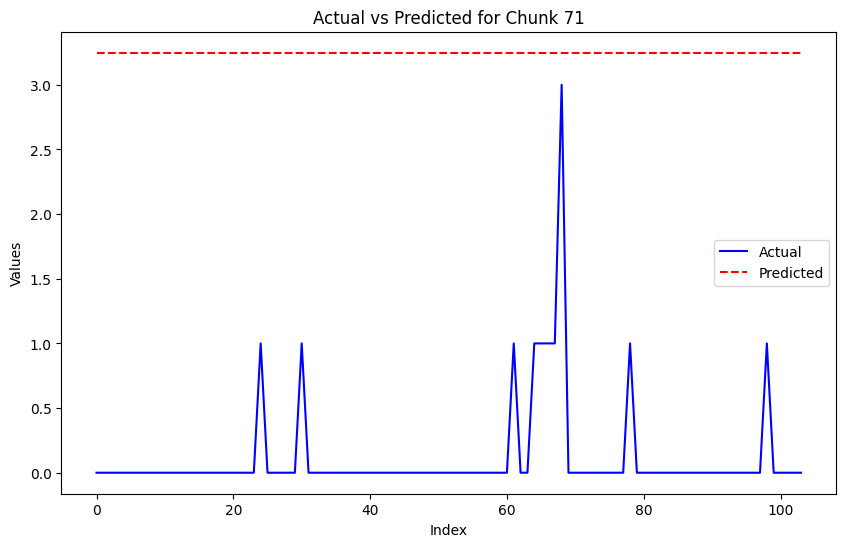

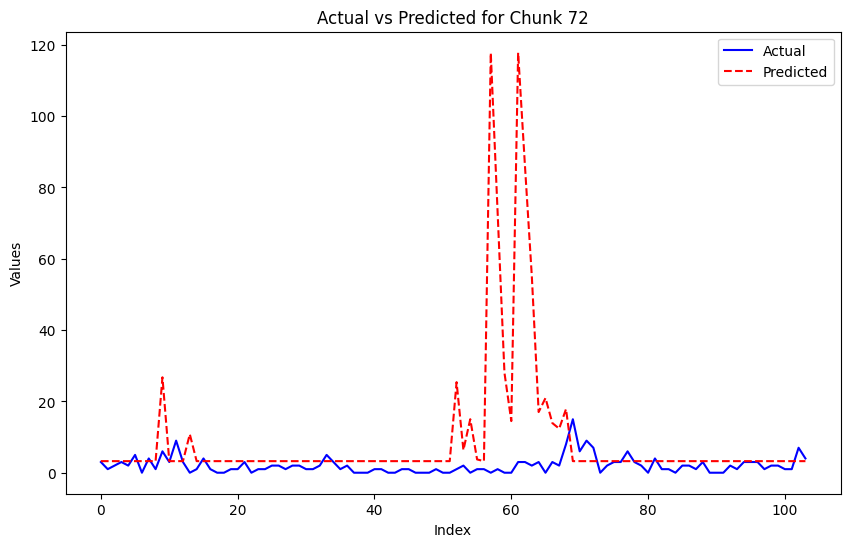

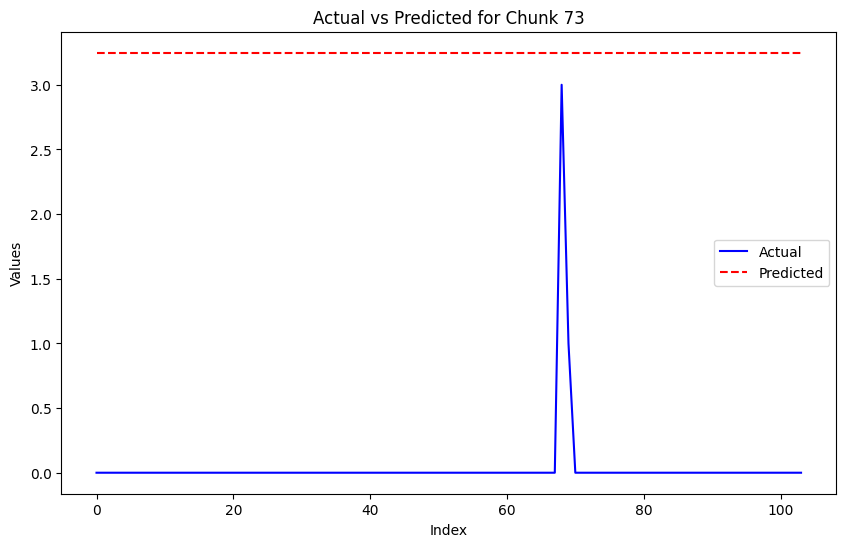

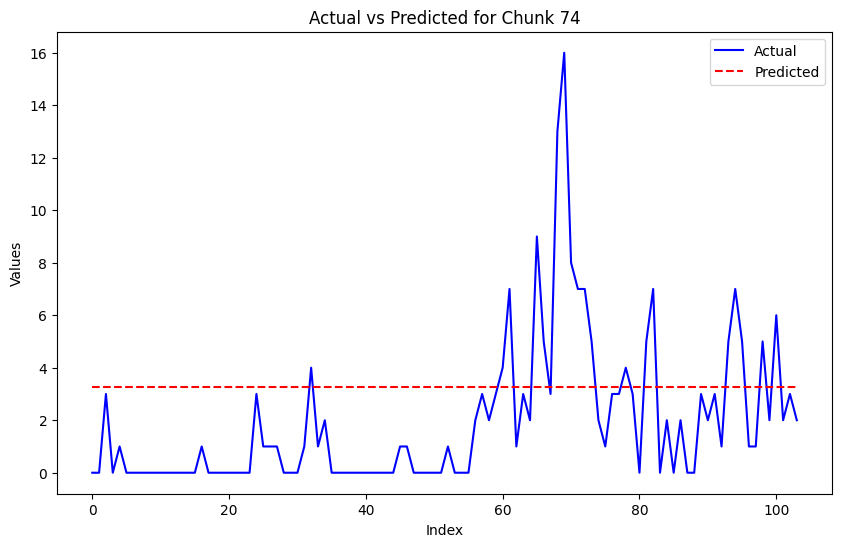

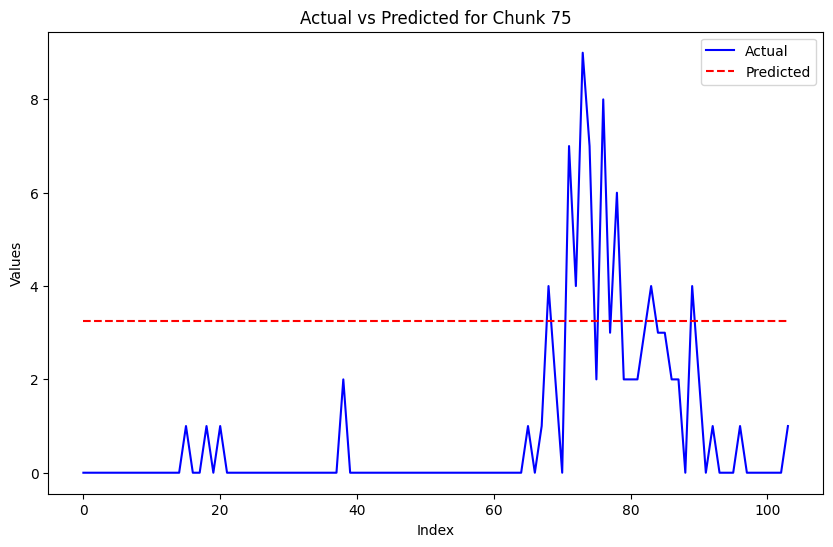

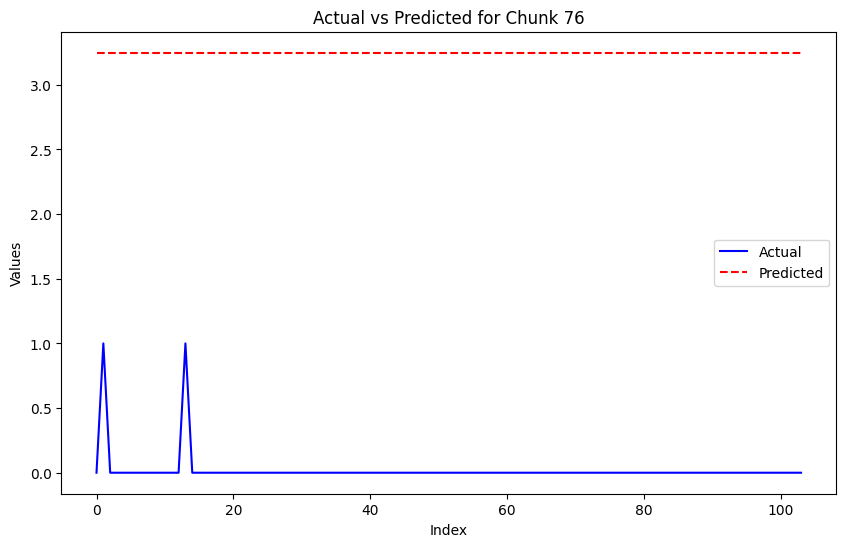

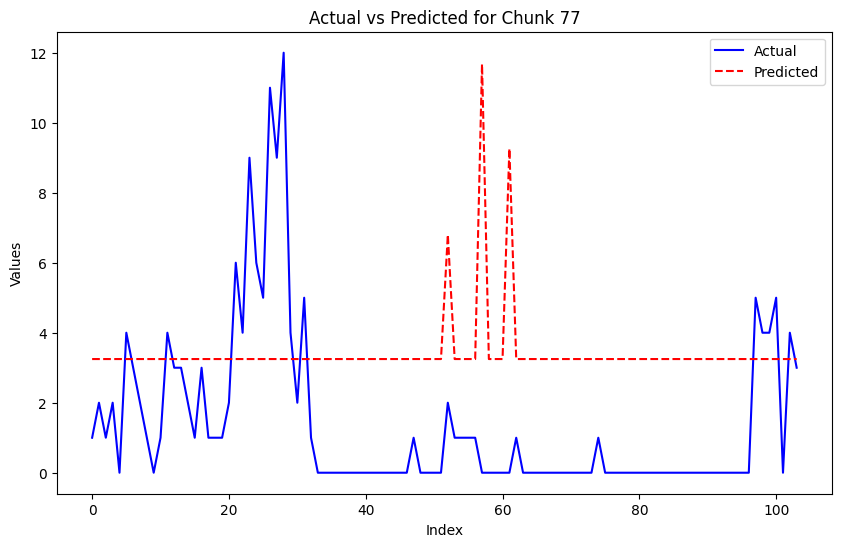

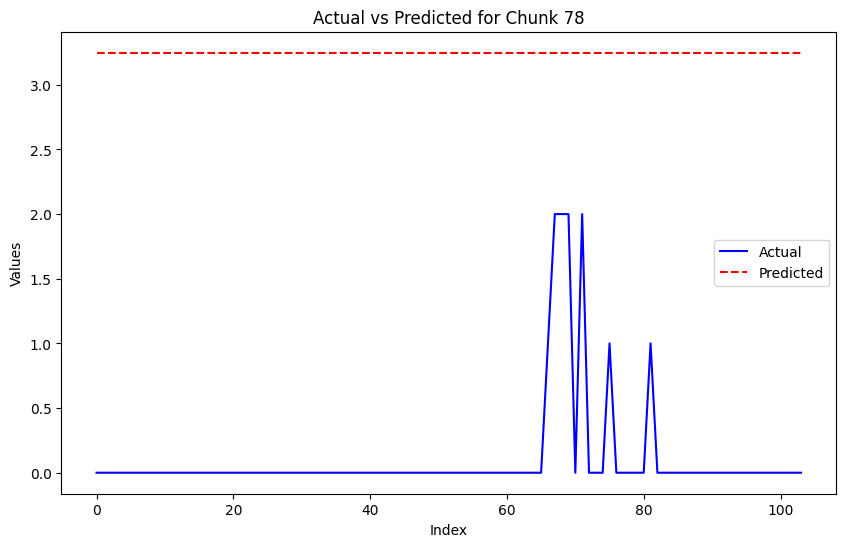

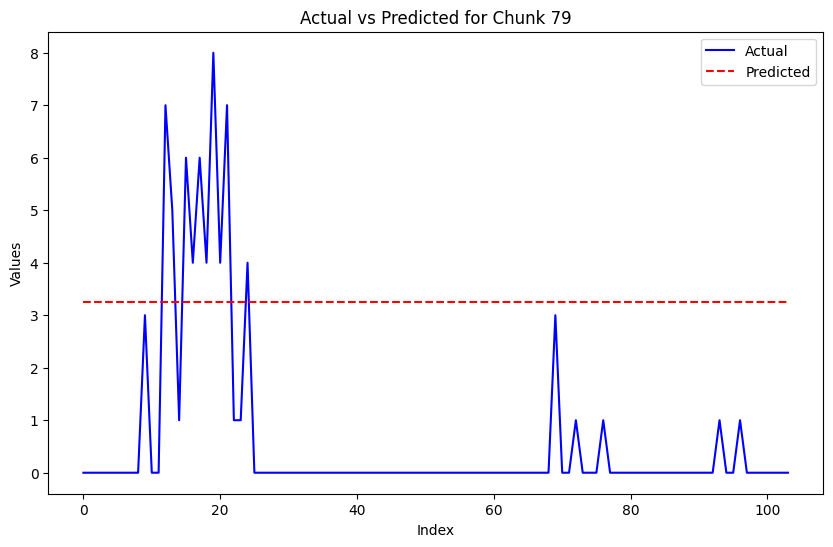

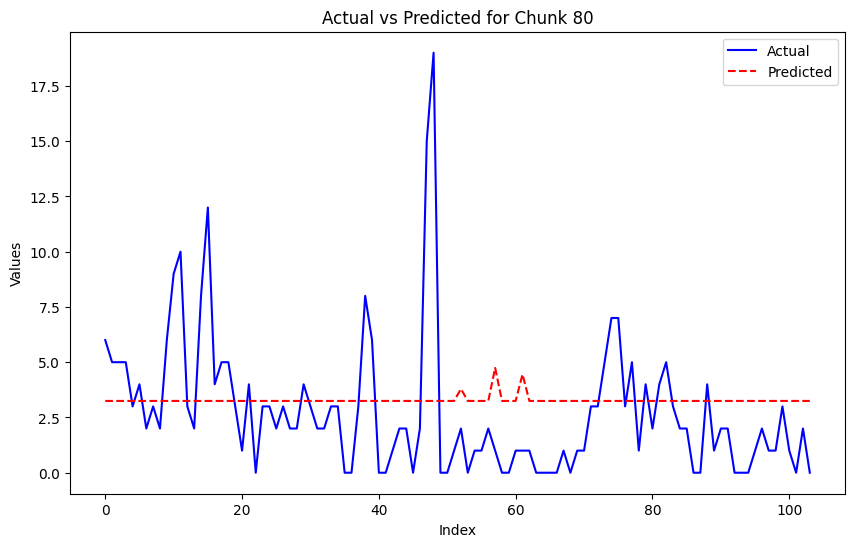

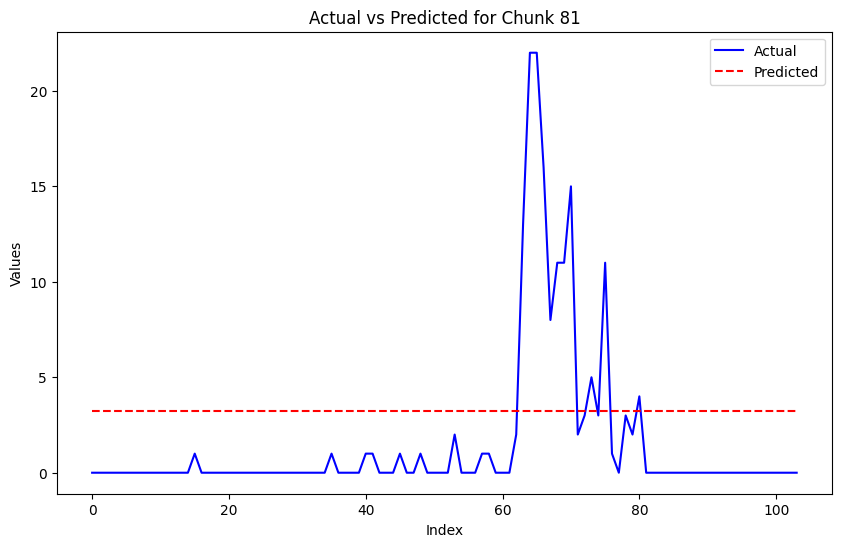

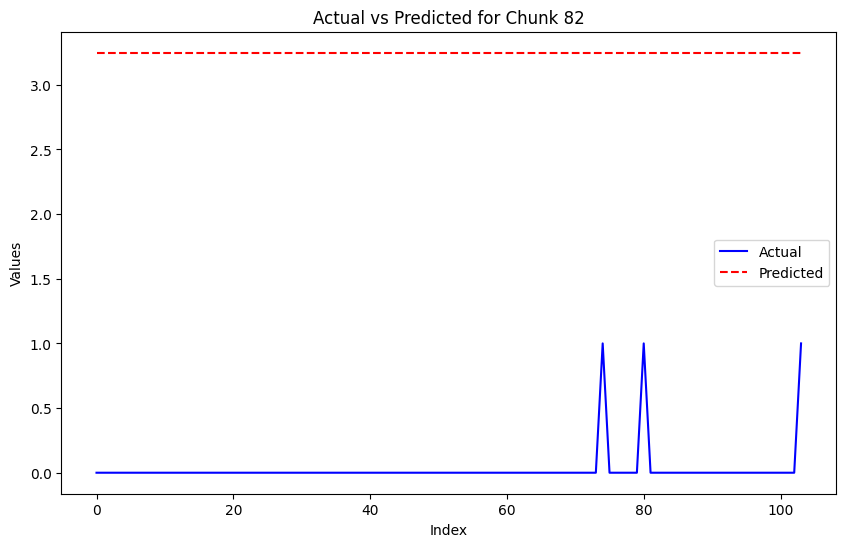

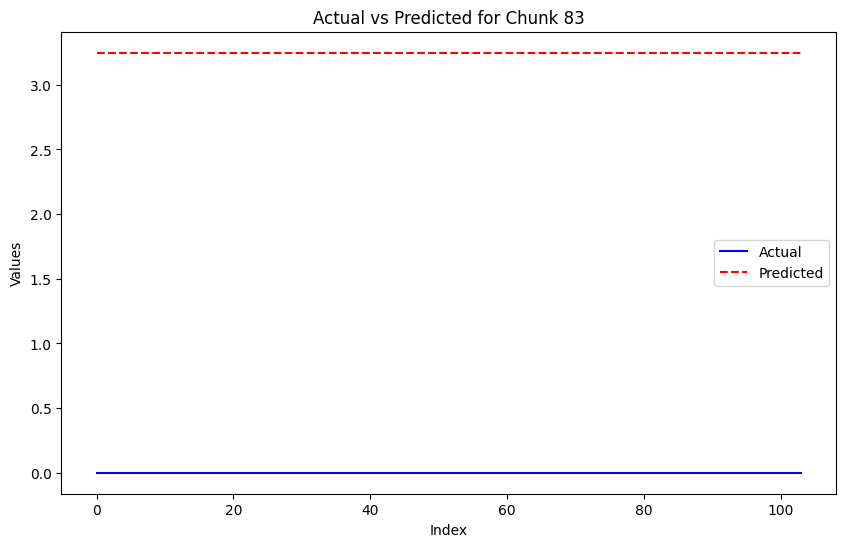

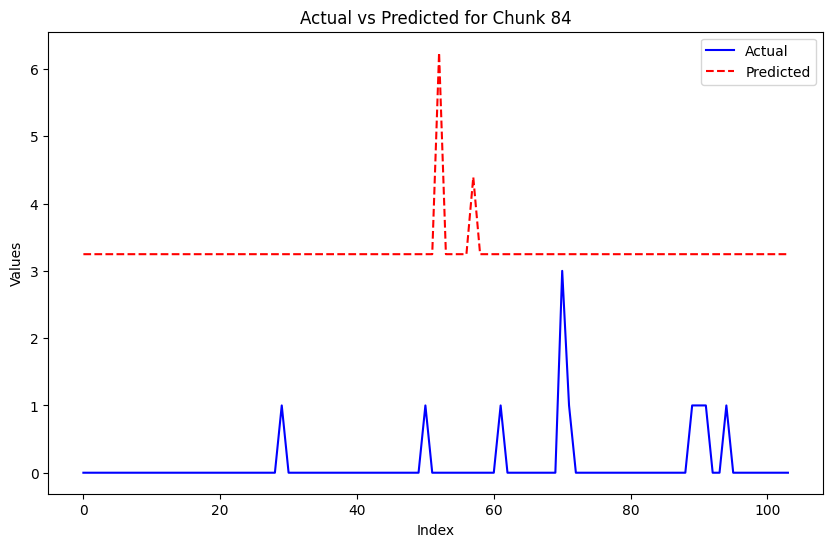

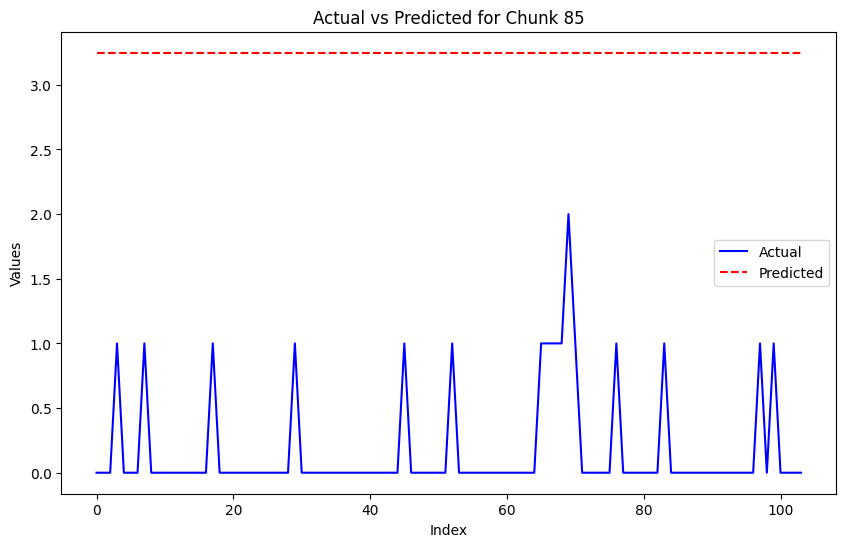

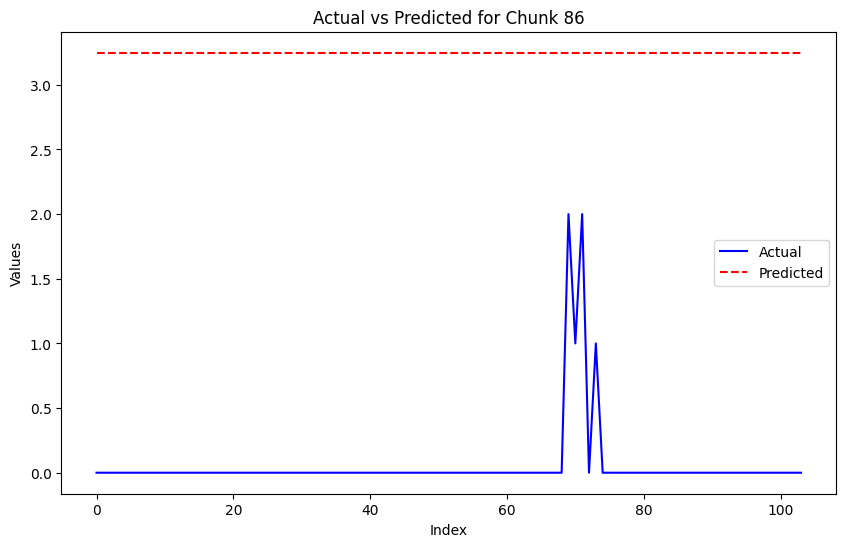

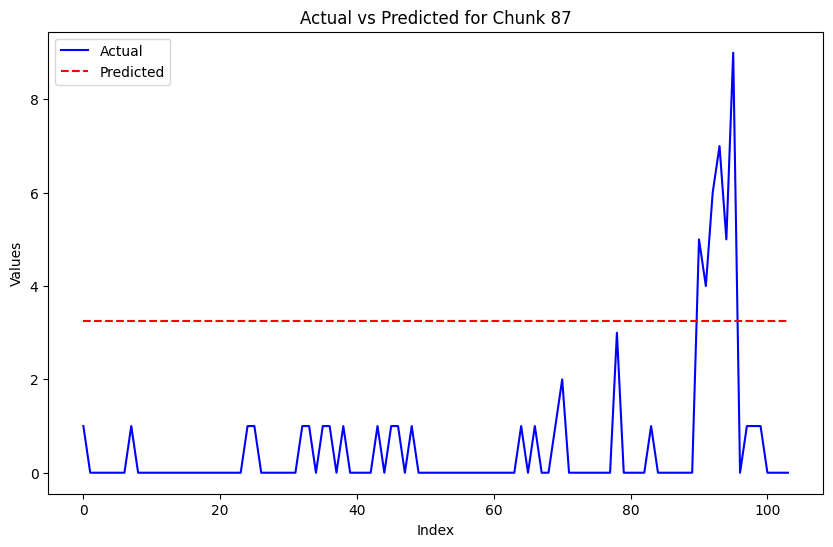

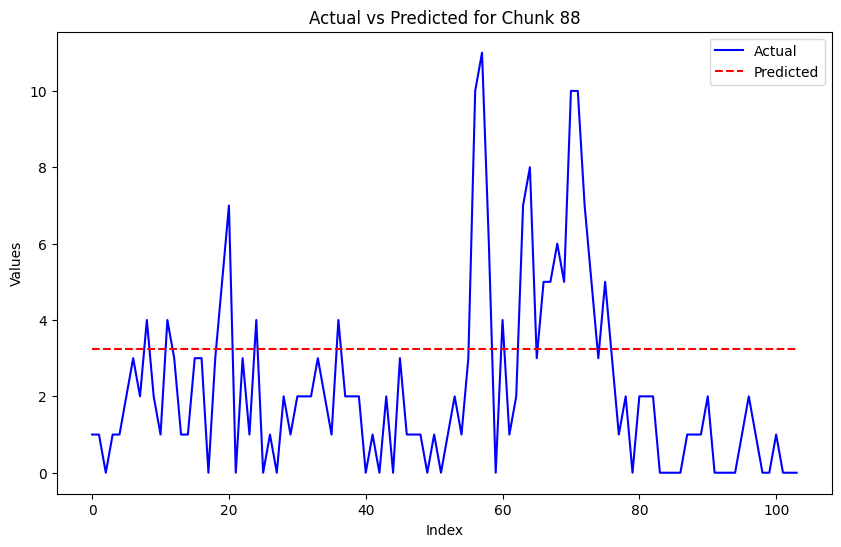

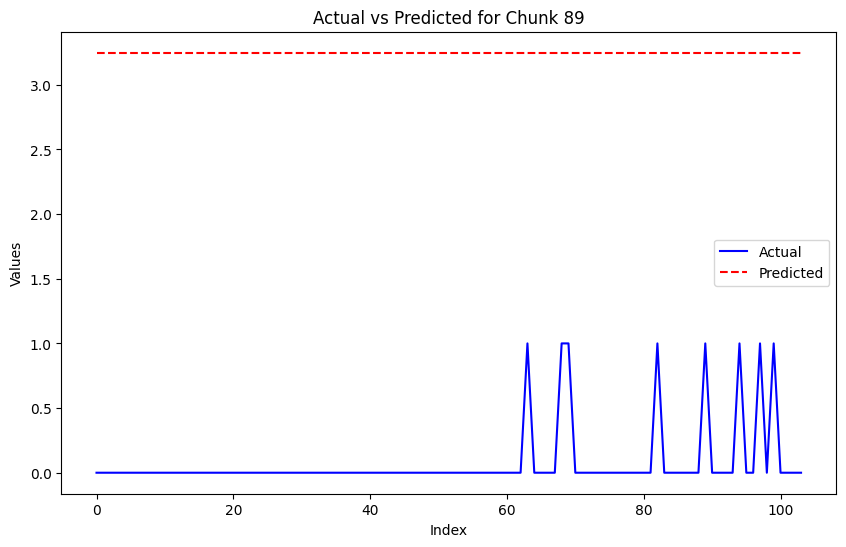

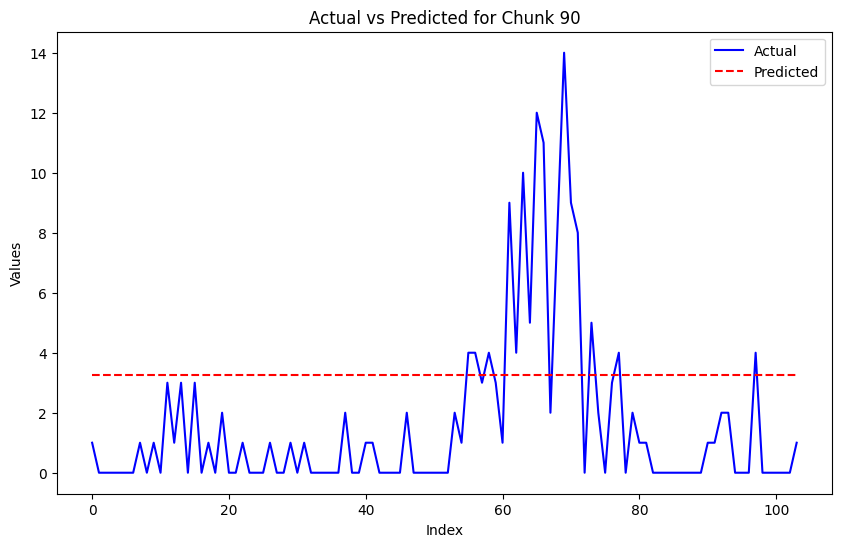

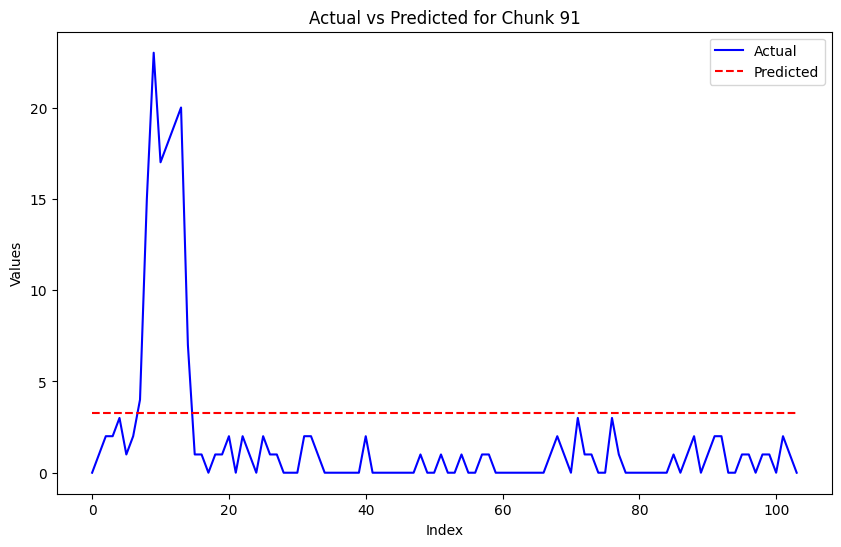

In [286]:
import matplotlib.pyplot as plt

# Rescale actual values back to the original scale
y_test_rescaled = target_scaler.inverse_transform(y_test)
test_predictions_rescaled = target_scaler.inverse_transform(test_predictions)

# Number of cases per plot (as you specified: 104)
chunk_size = 104
num_chunks = len(test_predictions_rescaled) // chunk_size

# Loop through each chunk and plot the actual vs predicted values
for i in range(num_chunks):
    # Get the start and end indices for the current chunk
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size
    
    # Get the actual and predicted values for the current chunk
    actual_chunk = y_test_rescaled[start_idx:end_idx]
    predicted_chunk = test_predictions_rescaled[start_idx:end_idx]
    
    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(actual_chunk, label='Actual', color='blue')
    plt.plot(predicted_chunk, label='Predicted', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted for Chunk {i+1}')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

In [36]:
# Function to create overlapping sequences
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length].values)  # Select seq_length rows as input
        y.append(target.iloc[i + seq_length])  # Select the next row as the target
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 4

# Group data by city
city_groups_xtrain = X_train.groupby('city')
city_groups_xtest = X_test.groupby('city')

city_groups_ytrain = y_train.groupby('city')
city_groups_ytest = y_test.groupby('city')

# Initialize dictionaries to store the processed data for each city
X_train_citywise_seq = {}
y_train_citywise_seq = {}
X_test_citywise_seq = {}
y_test_citywise_seq = {}

# Process training data city-wise
for city, X_train_city in city_groups_xtrain:
    y_train_city = city_groups_ytrain.get_group(city)  # Get the corresponding target group
    # Reset index to ensure continuous indexing
    y_train_city = y_train_city.reset_index(drop=True)
    X_seq, y_seq = create_sequences(X_train_city[feature_cols], y_train_city['cases'], seq_length)  # Use 'cases' as target
    X_train_citywise_seq[city] = X_seq
    y_train_citywise_seq[city] = y_seq
    print(f"Processed X_train and y_train for city: {city}, X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")

# Process testing data city-wise
for city, X_test_city in city_groups_xtest:
    y_test_city = city_groups_ytest.get_group(city)  # Get the corresponding target group
    # Reset index to ensure continuous indexing
    y_test_city = y_test_city.reset_index(drop=True)
    X_seq, y_seq = create_sequences(X_test_city[feature_cols], y_test_city['cases'], seq_length)  # Use 'cases' as target
    X_test_citywise_seq[city] = X_seq
    y_test_citywise_seq[city] = y_seq
    print(f"Processed X_test and y_test for city: {city}, X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")


Processed X_train and y_train for city: angra dos reis, X_seq shape: (462, 4, 10), y_seq shape: (462,)
Processed X_train and y_train for city: aperibé, X_seq shape: (466, 4, 10), y_seq shape: (466,)
Processed X_train and y_train for city: araruama, X_seq shape: (466, 4, 10), y_seq shape: (466,)
Processed X_train and y_train for city: areal, X_seq shape: (466, 4, 10), y_seq shape: (466,)
Processed X_train and y_train for city: armação dos búzios, X_seq shape: (466, 4, 10), y_seq shape: (466,)
Processed X_train and y_train for city: arraial do cabo, X_seq shape: (466, 4, 10), y_seq shape: (466,)
Processed X_train and y_train for city: barra do piraí, X_seq shape: (466, 4, 10), y_seq shape: (466,)
Processed X_train and y_train for city: barra mansa, X_seq shape: (466, 4, 10), y_seq shape: (466,)
Processed X_train and y_train for city: belford roxo, X_seq shape: (466, 4, 10), y_seq shape: (466,)
Processed X_train and y_train for city: bom jardim, X_seq shape: (466, 4, 10), y_seq shape: (46

In [37]:
# Define sequence length for LSTM
seq_length = 4

# Function to build and compile the model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)  # Predicting a single value (cases)
    ])
    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])
    return model

# Loop through each city dataset
city_models = {}
city_histories = {}
city_predictions = {}

for city in X_train_citywise_seq.keys():
    print(f"Processing city: {city}")

    # Get city-specific data
    X_train_city = X_train_citywise_seq[city]
    y_train_city = y_train_citywise_seq[city]
    X_test_city = X_test_citywise_seq[city]
    y_test_city = y_test_citywise_seq[city]

    # Ensure input shape matches the LSTM model
    input_shape = (seq_length, X_train_city.shape[2])

    # Build the model
    model = build_lstm_model(input_shape)

    # Train the model
    history = model.fit(
        X_train_city, y_train_city,
        epochs=50,
        batch_size=32,
        validation_data=(X_test_city, y_test_city),
        verbose=1
    )

    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test_city, y_test_city)
    print(f"City: {city}, Test Loss: {test_loss}, Test MAE: {test_mae}")

    # Save the model for this city
    model.save(f"lstm_dengue_prediction_model_{city}.h5")

    # Predict on test data
    predictions = model.predict(X_test_city)

    # Store results
    city_models[city] = model
    city_histories[city] = history
    city_predictions[city] = predictions

    print(f"Completed processing for city: {city}\n")

Processing city: angra dos reis


c:\Program Files\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 6.3702e-04 - mae: 0.0192 - val_loss: 1.4237e-04 - val_mae: 0.0097
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8736e-04 - mae: 0.0124 - val_loss: 5.9935e-05 - val_mae: 0.0069
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4020e-04 - mae: 0.0111 - val_loss: 3.2167e-05 - val_mae: 0.0044
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7506e-04 - mae: 0.0094 - val_loss: 2.9143e-05 - val_mae: 0.0048
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1053e-04 - mae: 0.0075 - val_loss: 5.5683e-05 - val_mae: 0.0063
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0622e-04 - mae: 0.0069 - val_loss: 4.3384e-05 - val_mae: 0.0048
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0196e-05 - mae: 0.0059 - val_loss: 4.1165e-05 - val_mae: 0.0048
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7277e-05 - mae: 0.0058 - val_loss: 2.6862e-05 - val_mae: 0.0038
Epoch 9

City: angra dos reis, Test Loss: 6.390536327671725e-06, Test MAE: 0.0016142583917826414
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
Completed processing for city: angra dos reis

Processing city: aperibé
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 6.5076e-04 - mae: 0.0194 - val_loss: 2.3886e-04 - val_mae: 0.0133
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0831e-04 - mae: 0.0113 - val_loss: 1.2747e-04 - val_mae: 0.0096
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5129e-04 - mae: 0.0096 - val_loss: 7.9246e-05 - val_mae: 0.0076
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1280e-04 - mae: 0.0081 - val_loss: 4.2579e-05 - val_mae: 0.0051
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9598e-05 - mae: 0.0080 - val_loss: 9.5243e-06 - val_mae: 0.0023
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6865e-05 - mae: 0.0063 - val_loss: 1.0840e-05 - val_mae: 0.0026
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss

City: aperibé, Test Loss: 7.477852363990678e-07, Test MAE: 0.0005250553949736059
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
Completed processing for city: aperibé

Processing city: araruama
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0017 - mae: 0.0287 - val_loss: 1.4404e-04 - val_mae: 0.0100
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4310e-04 - mae: 0.0143 - val_loss: 9.9500e-05 - val_mae: 0.0073
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3242e-04 - mae: 0.0085 - val_loss: 1.0487e-05 - val_mae: 0.0027
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7864e-05 - mae: 0.0062 - val_loss: 4.5104e-06 - val_mae: 0.0017
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6546e-05 - mae: 0.0048 - val_loss: 4.8984e-06 - val_mae: 0.0019
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9218e-05 - mae: 0.0031 - val_loss: 1.1316e-06 - val_mae: 9.8721e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0101e-05 

City: araruama, Test Loss: 1.4207068943505874e-07, Test MAE: 0.0003734336351044476


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E153762FC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Completed processing for city: araruama

Processing city: areal
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 6.2349e-04 - mae: 0.0190 - val_loss: 1.3757e-04 - val_mae: 0.0091
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.7531e-04 - mae: 0.0128 - val_loss: 1.2009e-04 - val_mae: 0.0089
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1791e-04 - mae: 0.0115 - val_loss: 1.0726e-04 - val_mae: 0.0081
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5203e-04 - mae: 0.0095 - val_loss: 7.7855e-05 - val_mae: 0.0078
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9313e-05 - mae: 0.0070 - val_loss: 4.5285e-05 - val_mae: 0.0056
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8715e-05 - mae: 0.0061 - val_loss: 2.7443e-05 - val_mae: 0.0048
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2232e-05 - mae: 0.0056 - val_loss: 1.3233e-05 - val_mae: 0.0029
Epoch 8/50
15/15 ━━━━━━━━━━━

City: areal, Test Loss: 9.116045163182207e-08, Test MAE: 0.00030177782173268497
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Completed processing for city: areal

Processing city: armação dos búzios
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0013 - mae: 0.0270 - val_loss: 2.5020e-04 - val_mae: 0.0129
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6616e-04 - mae: 0.0151 - val_loss: 9.6413e-05 - val_mae: 0.0074
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4052e-04 - mae: 0.0094 - val_loss: 6.4682e-05 - val_mae: 0.0069
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9170e-05 - mae: 0.0078 - val_loss: 2.2556e-05 - val_mae: 0.0041
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7258e-05 - mae: 0.0064 - val_loss: 1.3937e-05 - val_mae: 0.0031
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8212e-05 - mae: 0.0053 - val_loss: 1.4499e-05 - val_mae: 0.0031
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3496e-


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Completed processing for city: armação dos búzios

Processing city: arraial do cabo
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.2438e-04 - mae: 0.0191 - val_loss: 6.4528e-05 - val_mae: 0.0056
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4460e-04 - mae: 0.0119 - val_loss: 1.2509e-04 - val_mae: 0.0087
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0888e-04 - mae: 0.0080 - val_loss: 6.5708e-05 - val_mae: 0.0067
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8988e-05 - mae: 0.0072 - val_loss: 3.8597e-05 - val_mae: 0.0055
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3094e-05 - mae: 0.0053 - val_loss: 2.8558e-05 - val_mae: 0.0045
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8855e-05 - mae: 0.0047 - val_loss: 3.0681e-05 - val_mae: 0.0049
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7678e-05 - mae: 0.0040 - val_loss: 2.9851e-05 - val_mae: 0.0051
Epoch 8/

City: arraial do cabo, Test Loss: 1.148659691807552e-07, Test MAE: 0.00033502624137327075
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Completed processing for city: arraial do cabo

Processing city: barra do piraí
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 7.8377e-04 - mae: 0.0203 - val_loss: 1.4468e-04 - val_mae: 0.0101
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4443e-04 - mae: 0.0091 - val_loss: 4.7733e-05 - val_mae: 0.0056
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7027e-05 - mae: 0.0062 - val_loss: 2.6141e-05 - val_mae: 0.0042
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9296e-05 - mae: 0.0052 - val_loss: 8.6957e-06 - val_mae: 0.0025
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0926e-05 - mae: 0.0047 - val_loss: 3.7062e-06 - val_mae: 0.0017
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3538e-05 - mae: 0.0036 - val_loss: 5.2739e-06 - val_mae: 0.0021
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/st

City: barra do piraí, Test Loss: 1.020341755975096e-06, Test MAE: 0.0009460722794756293
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Completed processing for city: barra do piraí

Processing city: barra mansa
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0011 - mae: 0.0233 - val_loss: 6.5950e-05 - val_mae: 0.0069
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5777e-04 - mae: 0.0123 - val_loss: 5.2102e-05 - val_mae: 0.0055
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3721e-04 - mae: 0.0093 - val_loss: 5.0167e-05 - val_mae: 0.0054
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1071e-04 - mae: 0.0077 - val_loss: 4.5225e-05 - val_mae: 0.0052
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2829e-05 - mae: 0.0061 - val_loss: 2.3432e-05 - val_mae: 0.0039
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0588e-05 - mae: 0.0049 - val_loss: 1.4845e-05 - val_mae: 0.0030
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss

City: barra mansa, Test Loss: 1.9515716758178314e-06, Test MAE: 0.0011339413467794657
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Completed processing for city: barra mansa

Processing city: belford roxo
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.7398e-04 - mae: 0.0244 - val_loss: 1.4830e-04 - val_mae: 0.0106
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4885e-04 - mae: 0.0150 - val_loss: 6.8536e-05 - val_mae: 0.0069
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1656e-04 - mae: 0.0115 - val_loss: 5.2558e-05 - val_mae: 0.0063
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2603e-04 - mae: 0.0088 - val_loss: 2.6155e-05 - val_mae: 0.0043
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2492e-05 - mae: 0.0069 - val_loss: 1.3532e-05 - val_mae: 0.0030
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1376e-05 - mae: 0.0055 - val_loss: 1.1236e-05 - val_mae: 0.0028
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss:

City: belford roxo, Test Loss: 4.996410325475154e-07, Test MAE: 0.00039646736695431173
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
Completed processing for city: belford roxo

Processing city: bom jardim
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 6.1669e-04 - mae: 0.0190 - val_loss: 4.7860e-05 - val_mae: 0.0056
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9372e-04 - mae: 0.0100 - val_loss: 1.9293e-05 - val_mae: 0.0038
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.3983e-05 - mae: 0.0072 - val_loss: 1.2264e-05 - val_mae: 0.0032
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8541e-05 - mae: 0.0058 - val_loss: 9.2516e-06 - val_mae: 0.0026
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9822e-05 - mae: 0.0048 - val_loss: 1.5207e-05 - val_mae: 0.0034
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5852e-05 - mae: 0.0046 - val_loss: 7.0163e-06 - val_mae: 0.0022
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

City: bom jardim, Test Loss: 2.156475602532737e-07, Test MAE: 0.00041622796561568975
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step
Completed processing for city: bom jardim

Processing city: bom jesus do itabapoana
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 6.5879e-04 - mae: 0.0199 - val_loss: 1.1787e-04 - val_mae: 0.0093
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0534e-04 - mae: 0.0130 - val_loss: 6.3354e-05 - val_mae: 0.0065
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7849e-04 - mae: 0.0102 - val_loss: 5.0148e-05 - val_mae: 0.0060
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0320e-04 - mae: 0.0077 - val_loss: 1.6124e-05 - val_mae: 0.0034
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.1890e-05 - mae: 0.0066 - val_loss: 7.3504e-06 - val_mae: 0.0022
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6611e-05 - mae: 0.0049 - val_loss: 1.8215e-06 - val_mae: 0.0011
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step
Completed processing for city: bom jesus do itabapoana

Processing city: cabo frio
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.0011 - mae: 0.0254 - val_loss: 1.2210e-04 - val_mae: 0.0093
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.1695e-04 - mae: 0.0159 - val_loss: 5.9279e-05 - val_mae: 0.0063
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.5127e-04 - mae: 0.0120 - val_loss: 7.2797e-05 - val_mae: 0.0072
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.9345e-04 - mae: 0.0107 - val_loss: 6.0376e-05 - val_mae: 0.0063
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.1701e-04 - mae: 0.0081 - val_loss: 1.1461e-05 - val_mae: 0.0029
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.4907e-05 - mae: 0.0067 - val_loss: 7.0224e-06 - val_mae: 0.0023
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.8845e-05 - mae: 0.0054 - val_loss: 1.3749e-05 - val_mae: 0.0034
Epoch 

City: cabo frio, Test Loss: 3.899321200151462e-06, Test MAE: 0.0014310174155980349
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step
Completed processing for city: cabo frio

Processing city: cachoeiras de macacu
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0017 - mae: 0.0282 - val_loss: 1.1208e-04 - val_mae: 0.0083
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.5412e-04 - mae: 0.0123 - val_loss: 5.6522e-05 - val_mae: 0.0060
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9105e-04 - mae: 0.0109 - val_loss: 5.5817e-05 - val_mae: 0.0064
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6264e-04 - mae: 0.0102 - val_loss: 2.2483e-05 - val_mae: 0.0042
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3501e-04 - mae: 0.0092 - val_loss: 2.5723e-05 - val_mae: 0.0042
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0100e-04 - mae: 0.0078 - val_loss: 1.5951e-05 - val_mae: 0.0033
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step -

City: cachoeiras de macacu, Test Loss: 3.6079879350836563e-07, Test MAE: 0.0005475841462612152
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step
Completed processing for city: cachoeiras de macacu

Processing city: cambuci
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0013 - mae: 0.0264 - val_loss: 1.5987e-04 - val_mae: 0.0111
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.8111e-04 - mae: 0.0132 - val_loss: 1.4424e-04 - val_mae: 0.0090
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5704e-04 - mae: 0.0091 - val_loss: 8.2513e-05 - val_mae: 0.0068
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.0435e-05 - mae: 0.0067 - val_loss: 1.7006e-05 - val_mae: 0.0030
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0152e-05 - mae: 0.0047 - val_loss: 3.5723e-06 - val_mae: 0.0016
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0471e-05 - mae: 0.0037 - val_loss: 2.7196e-06 - val_mae: 0.0014
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1

City: cambuci, Test Loss: 7.769286725078928e-08, Test MAE: 0.00020770248374901712
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step
Completed processing for city: cambuci

Processing city: campos dos goytacazes
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0016 - mae: 0.0286 - val_loss: 2.4809e-04 - val_mae: 0.0126
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6544e-04 - mae: 0.0155 - val_loss: 1.7038e-04 - val_mae: 0.0107
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3582e-04 - mae: 0.0133 - val_loss: 7.8816e-05 - val_mae: 0.0076
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.8769e-04 - mae: 0.0125 - val_loss: 7.2944e-05 - val_mae: 0.0073
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.0220e-04 - mae: 0.0116 - val_loss: 9.9043e-05 - val_mae: 0.0079
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.0924e-04 - mae: 0.0108 - val_loss: 4.4848e-05 - val_mae: 0.0051
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - l


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step
Completed processing for city: campos dos goytacazes

Processing city: cantagalo
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 8.1896e-05 - val_mae: 0.0074
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4729e-04 - mae: 0.0147 - val_loss: 1.0115e-04 - val_mae: 0.0075
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0485e-04 - mae: 0.0111 - val_loss: 2.7780e-05 - val_mae: 0.0044
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5733e-04 - mae: 0.0098 - val_loss: 2.1732e-05 - val_mae: 0.0034
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0216e-04 - mae: 0.0076 - val_loss: 3.5183e-06 - val_mae: 0.0016
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5032e-05 - mae: 0.0056 - val_loss: 1.8375e-05 - val_mae: 0.0037
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5035e-05 - mae: 0.0050 - val_loss: 4.2635e-06 - val_mae: 0.0017
Epoch 8/

City: cantagalo, Test Loss: 2.7971665872428275e-07, Test MAE: 0.0005252321134321392
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step
Completed processing for city: cantagalo

Processing city: carapebus
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 8.8169e-04 - mae: 0.0227 - val_loss: 1.0434e-04 - val_mae: 0.0087
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9709e-04 - mae: 0.0112 - val_loss: 7.4750e-05 - val_mae: 0.0070
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.1206e-04 - mae: 0.0083 - val_loss: 2.5465e-05 - val_mae: 0.0039
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.1368e-05 - mae: 0.0066 - val_loss: 1.2393e-05 - val_mae: 0.0023
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.7077e-05 - mae: 0.0046 - val_loss: 9.0931e-06 - val_mae: 0.0021
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2260e-05 - mae: 0.0034 - val_loss: 7.9805e-06 - val_mae: 0.0020
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss:

City: carapebus, Test Loss: 8.493699965583801e-08, Test MAE: 0.0002639192680362612
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step
Completed processing for city: carapebus

Processing city: cardoso moreira
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 8.8117e-04 - mae: 0.0221 - val_loss: 1.7916e-04 - val_mae: 0.0114
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2353e-04 - mae: 0.0118 - val_loss: 8.7723e-05 - val_mae: 0.0078
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4831e-04 - mae: 0.0097 - val_loss: 1.0379e-04 - val_mae: 0.0084
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0891e-04 - mae: 0.0081 - val_loss: 4.5115e-05 - val_mae: 0.0054
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1904e-04 - mae: 0.0081 - val_loss: 3.3721e-05 - val_mae: 0.0049
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8534e-05 - mae: 0.0060 - val_loss: 2.5749e-05 - val_mae: 0.0042
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

City: cardoso moreira, Test Loss: 3.552377165760845e-07, Test MAE: 0.00057987030595541
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Completed processing for city: cardoso moreira

Processing city: carmo
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 7.7765e-04 - mae: 0.0206 - val_loss: 1.1206e-04 - val_mae: 0.0081
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7521e-04 - mae: 0.0095 - val_loss: 3.8921e-05 - val_mae: 0.0055
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6164e-05 - mae: 0.0061 - val_loss: 1.8591e-05 - val_mae: 0.0033
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0478e-05 - mae: 0.0053 - val_loss: 1.4836e-05 - val_mae: 0.0031
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4238e-05 - mae: 0.0045 - val_loss: 7.8881e-06 - val_mae: 0.0025
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.0306e-05 - mae: 0.0033 - val_loss: 8.7366e-06 - val_mae: 0.0025
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 

City: carmo, Test Loss: 2.9941227808194526e-07, Test MAE: 0.0004165932477917522
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Completed processing for city: carmo

Processing city: casimiro de abreu
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 7.2041e-04 - mae: 0.0205 - val_loss: 6.2279e-05 - val_mae: 0.0068
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6633e-04 - mae: 0.0129 - val_loss: 3.6496e-05 - val_mae: 0.0050
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5351e-04 - mae: 0.0092 - val_loss: 3.1888e-05 - val_mae: 0.0045
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.3915e-05 - mae: 0.0068 - val_loss: 2.5717e-05 - val_mae: 0.0044
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9599e-05 - mae: 0.0065 - val_loss: 1.4824e-05 - val_mae: 0.0031
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6338e-05 - mae: 0.0054 - val_loss: 1.2731e-05 - val_mae: 0.0031
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.933

City: casimiro de abreu, Test Loss: 8.470907886248824e-08, Test MAE: 0.000248455791734159
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Completed processing for city: casimiro de abreu

Processing city: comendador levy gasparian
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0011 - mae: 0.0241 - val_loss: 8.6030e-05 - val_mae: 0.0073
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0793e-04 - mae: 0.0136 - val_loss: 4.2170e-05 - val_mae: 0.0056
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7744e-04 - mae: 0.0103 - val_loss: 5.3960e-05 - val_mae: 0.0063
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0417e-05 - mae: 0.0070 - val_loss: 8.8417e-06 - val_mae: 0.0026
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9077e-05 - mae: 0.0059 - val_loss: 8.6230e-06 - val_mae: 0.0024
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2781e-05 - mae: 0.0051 - val_loss: 4.1648e-06 - val_mae: 0.0017
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━

City: comendador levy gasparian, Test Loss: 2.3332815146659414e-07, Test MAE: 0.0004464842495508492
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
Completed processing for city: comendador levy gasparian

Processing city: conceição de macabu
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 3.0774e-04 - mae: 0.0137 - val_loss: 7.0574e-05 - val_mae: 0.0055
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.4419e-04 - mae: 0.0091 - val_loss: 6.9607e-05 - val_mae: 0.0066
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.3642e-05 - mae: 0.0069 - val_loss: 3.1171e-05 - val_mae: 0.0044
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.5859e-05 - mae: 0.0057 - val_loss: 1.4951e-05 - val_mae: 0.0031
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.1250e-05 - mae: 0.0047 - val_loss: 8.3359e-06 - val_mae: 0.0024
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.6129e-05 - mae: 0.0042 - val_loss: 4.5156e-06 - val_mae: 0.0018
Epoch 7/50
15/15

City: conceição de macabu, Test Loss: 9.822353774779913e-08, Test MAE: 0.0002811647136695683
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step
Completed processing for city: conceição de macabu

Processing city: cordeiro
Epoch 1/50
 9/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - mae: 0.0295 

KeyboardInterrupt: 

City: paraty - Actual Values Shape: (100,)
City: paraty - Predicted Values Shape: (100,)


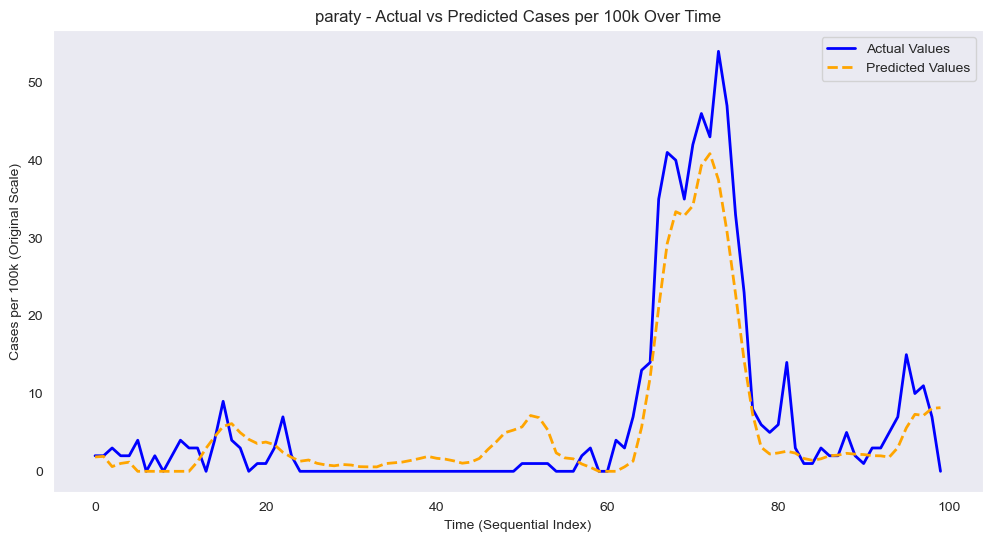

City: paraty - RMSE: 4.557026143966967


In [ ]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Function to plot Actual vs Predicted and calculate RMSE
def plot_actual_vs_predicted(city, y_test_city, predictions_city, target_scaler):
    # Ensure to only pass the target variable (numeric values) to the scaler
    y_test_values = y_test_city['cases'].values  # Assuming 'cases' is the target column
    predictions_original_scale = target_scaler.inverse_transform(predictions_city)
    actual_values_original_scale = target_scaler.inverse_transform(y_test_values.reshape(-1, 1))  # Reshape for scaling

    # Ensure both predictions and actual values have the same length
    min_length = min(len(actual_values_original_scale), len(predictions_original_scale))

    actual_values_original_scale = actual_values_original_scale[:min_length].flatten()
    predictions_original_scale = predictions_original_scale[:min_length].flatten()
    predictions_original_scale[predictions_original_scale < 0] = 0

    time_index = np.arange(min_length)

    # Print shapes
    print(f"City: {city} - Actual Values Shape:", actual_values_original_scale.shape)
    print(f"City: {city} - Predicted Values Shape:", predictions_original_scale.shape)

    # Plot Actual vs Predicted
    plt.figure(figsize=(12, 6))
    plt.plot(time_index, actual_values_original_scale, label="Actual Values", color='blue', linewidth=2)
    plt.plot(time_index, predictions_original_scale, label="Predicted Values", color='orange', linewidth=2, linestyle='--')
    plt.xlabel("Time (Sequential Index)")
    plt.ylabel("Cases per 100k (Original Scale)")
    plt.title(f"{city} - Actual vs Predicted Cases per 100k Over Time")
    plt.legend()
    plt.grid()
    plt.show()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_values_original_scale, predictions_original_scale))
    print(f"City: {city} - RMSE: {rmse}")

# Loop through each city's predictions and plot
for city in city_predictions.keys():
    predictions_city = city_predictions[city]
    y_test_city = city_groups_ytest.get_group(city)

    # Call the function to plot and calculate RMSE
    plot_actual_vs_predicted(city, y_test_city, predictions_city, target_scaler)